In [5]:
import os
import pickle
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize
import traceback
import matplotlib.gridspec as gridspec
import importlib
import StellarDMTracing as sdt



In [109]:
import numpy as np
import pandas as pd

def analyze_sim_data_similarity(sims, masses, mb, rvir,mvir, feedback_type):
    # Convert masses from log10 space
    
    data = {'masses': masses, 'sims': sims, 'feedback_type': feedback_type}
    
    masses = 10**data['masses']
    sim_list = []
    
    mass_mask = np.ones(len(masses), dtype=bool)
    
    for sim in sims:
        if sim in sim_list:
            continue
        sim_mask = data['sims'] == sim
        sidm_mask = sim_mask & (data['feedback_type'] == 'MerianSIDM')
        cdm_mask = sim_mask & (data['feedback_type'] == 'MerianCDM')
        
        if np.any(sidm_mask) and np.any(cdm_mask):
            print(f"\nComparison for simulation {sim}:")
            
            # Compare masses
            mass_diff = (masses[sidm_mask][0] - masses[cdm_mask][0])
            mass_rel_diff = (mass_diff / masses[sidm_mask][0])
 
            #print(f"Relative mass difference: {mass_rel_diff:.2%}")
            # if abs(mass_rel_diff) > 0.3:
            #     mass_mask[sidm_mask] = False
            #     mass_mask[cdm_mask] = False
                
            # Compare baryon fractions
            mb_diff = (mb[sidm_mask][0] - mb[cdm_mask][0])
            mb_rel_diff = (mb_diff / mb[sidm_mask][0])

            #print(f"Relative baryon fraction difference: {mb_rel_diff:.2%}")
            
            # Compare virial radii
            rvir_diff = (rvir[sidm_mask][0] - rvir[cdm_mask][0])
            rvir_rel_diff = (rvir_diff / rvir[sidm_mask][0])

            print(f"Relative virial radius difference: {rvir_rel_diff:.2%}")
            #mvir
            mvir_diff = (mvir[sidm_mask][0] - mvir[cdm_mask][0])
            mvir_rel_diff = (mvir_diff / mvir[sidm_mask][0])
            print(f'Relative mvir difference: {mvir_rel_diff:.2%}')
            
            
            
            
        sim_list.append(sim)
        
        
    


    return mass_mask

# Usage:
# differences = analyze_sim_data_similarity(sims, masses, mvir, rvir, feedback_type)

In [110]:

# add ../ to path
import sys
import os
sys.path.append('/home/bk639/MorphologyMeasurements/Code')

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from typing import List, Dict, Optional, Callable, Tuple
#reset to default matplotlib settings
plt.rcdefaults()


class GeneralPlotter:
    def __init__(self, data: Dict[str, np.ndarray], masks: Dict[str, np.ndarray],
                 labels: Dict[str, str], colors: Dict[str, str]):
        self.data = data
        self.masks = masks
        self.labels = labels
        self.colors = colors
        self.legend_fontsize = 20
        self.axis_fontsize = 33
        self.tick_fontsize = 20
        self.point_size = 120
        self.bin_count = 15
        reff = data['reff_multi']
        if reff != 1:
            self.suptitle = rf'{reff}R$_{{eff}}$'
        else:
            self.suptitle = rf'R$_{{eff}}$'

    def lighten_color(self, color: str, amount: float = 0.5) -> str:
        """
        Lightens the given color by multiplying (1-luminosity) by the given amount.
        """
        import colorsys
        try:
            c = plt.matplotlib.colors.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*plt.matplotlib.colors.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

    def plot_main(self, ax: plt.Axes, x_key: str, y_key: str, show_scatter: bool = True,
                  show_lines: bool = True, link_sims: bool = False):
        size = self.point_size
        
    
        for mask_name, mask in self.masks.items():
            color = self.colors[mask_name]
            dm_color = self.lighten_color(color, 1.5)

            if show_scatter:
                ax.scatter(self.data[f'{x_key}_d'][mask], self.data[f'{y_key}_d'][mask],
                           c=color, marker='o', s=size, alpha=.5, zorder=10,edgecolors='white')
                ax.scatter(self.data[f'{x_key}_s'][mask], self.data[f'{y_key}_s'][mask],
                           c=color, marker='*', s=size*4, alpha=.5,zorder=10,edgecolors='white')

            if show_lines or not show_scatter:
                for i in np.where(mask)[0]:
                    if show_scatter:
                        ax.plot([self.data[f'{x_key}_s'][i], self.data[f'{x_key}_d'][i]],
                                [self.data[f'{y_key}_s'][i], self.data[f'{y_key}_d'][i]],
                                zorder=0, lw=0.5, c='k', alpha=0.7)
                    else:
                        ax.plot([self.data[f'{x_key}_s'][i], self.data[f'{x_key}_d'][i]],
                                [self.data[f'{y_key}_s'][i], self.data[f'{y_key}_d'][i]],
                                zorder=0, lw=1, c=color, alpha=0.7)
            if show_lines or not show_scatter:
                if link_sims:
                    #link lines across feedback types for sims with the same name
                    #link lines from _s to _s and _d to _d of different feedbacks
                    
                    #find unique sims
                    sims = np.unique(self.data['sims'][mask])
                    # loop over each unique sim and plot lines across feedback types
                    for sim in sims:
                        #find indices of sims
                        indices = np.where(self.data['sims'] == sim)[0]
                        #for each index, find out which feedback type it is
                        for index in indices:
                            if self.data['feedback_type'][index] == 'MerianSIDM':
                                sidm_index = index
                            elif self.data['feedback_type'][index] == 'MerianCDM':
                                cdm_index = index
                            else:
                                print('Error: feedback type not recognized')
                                print(self.data['feedback_type'][index])
                                break
                        #plot line
                        ax.plot([self.data[f'{x_key}_s'][sidm_index], self.data[f'{x_key}_s'][cdm_index]],
                                [self.data[f'{y_key}_s'][sidm_index], self.data[f'{y_key}_s'][cdm_index]],
                                zorder=0, lw=1, c='k', alpha=0.7)
                        ax.plot([self.data[f'{x_key}_d'][sidm_index], self.data[f'{x_key}_d'][cdm_index]],
                                [self.data[f'{y_key}_d'][sidm_index], self.data[f'{y_key}_d'][cdm_index]],
                                zorder=0, lw=1, c='k', alpha=0.7)

                



    def plot_histograms(self, ax_histx: plt.Axes, ax_histy: plt.Axes,
                        ax_histx1: plt.Axes, ax_histy1: plt.Axes,
                        x_key: str, y_key: str):
        bins = np.linspace(0, 1, self.bin_count + 1)
        lw = 2
        linestyles = ['-', '--', '-.', ':']

        for mask_name, mask in self.masks.items():
            color = self.colors[mask_name]
            density=False
            ax_histx.hist(self.data[f'{x_key}_s'][mask], bins=bins, density=density, histtype='step', color=color, lw=lw,
                          ls=linestyles[0],alpha = 1)

            ax_histy.hist(self.data[f'{y_key}_s'][mask], bins=bins, density=density, histtype='step',
                          orientation='horizontal', color=color, lw=lw, ls = linestyles[0],alpha=1)

            ax_histx1.hist(self.data[f'{x_key}_d'][mask], bins=bins, density=density, histtype='step', color=color, lw=lw,
                           ls=linestyles[1])

            ax_histy1.hist(self.data[f'{y_key}_d'][mask], bins=bins, density=density, histtype='step',
                           orientation='horizontal', color=color, lw=lw, ls=linestyles[1])

    def plot_data_with_masks(self, x_key: str, y_key: str, show_lines: bool = False,
                             show_scatter: bool = True, filename: str = None, link_sims: bool = False):
        fig = plt.figure(figsize=(10, 10),dpi=100)
        gs = gridspec.GridSpec(5, 5, height_ratios=[1, 1, 3, 3, 3], width_ratios=[3, 3, 3, 1, 1])
        ax_main = plt.subplot(gs[2:5, 0:3])
        ax_histx = plt.subplot(gs[1, 0:3], sharex=ax_main)
        ax_histx1 = plt.subplot(gs[0, 0:3], sharex=ax_main)
        ax_histy = plt.subplot(gs[2:5, 3], sharey=ax_main)
        ax_histy1 = plt.subplot(gs[2:5, 4], sharey=ax_main)

        self.plot_main(ax_main, x_key, y_key, show_scatter, show_lines, link_sims)
        self.plot_histograms(ax_histx, ax_histy, ax_histx1, ax_histy1, x_key, y_key)

        # Set up legends, labels, and grid
        for mask_name, color in self.colors.items():
            if show_scatter:
                ax_main.scatter(-1, -1, c=color, marker='o', s=self.point_size, label=f'{self.labels[mask_name]}')
            else:
                ax_main.plot([], [], c=color)

        if show_scatter:
            ax_main.scatter(-1, -1, c='gray', marker='o', s=self.point_size, label='Dark Matter')
            ax_main.scatter(-1, -1, c='gray', marker='*', s=self.point_size, label='Stars')


        ax_main.legend(loc='upper left', fontsize=self.legend_fontsize)
        ax_main.set_xlabel(rf'${self.labels[x_key]} = {x_key[0].upper()}/A$ ({self.suptitle})', fontsize=self.axis_fontsize)
        ax_main.set_ylabel(rf'${self.labels[y_key]} = {y_key[0].upper()}/A$ ({self.suptitle})', fontsize=self.axis_fontsize)
        ax_main.set_xlim([0, 1])
        ax_main.set_ylim([0, 1])
        ax_main.plot([0, 1], [0, 1], c='0.5', linestyle='--')
        #make grid last so it doesn't interfere with the plot
        #ax_main.grid(True, zorder = 0)
        ax_main.tick_params(which='both', labelsize=self.tick_fontsize)

        # Remove tick marks for histograms
        for ax in [ax_histx, ax_histx1, ax_histy, ax_histy1]:
            ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                           labelbottom=False, labelleft=False)

        # Add legends for histograms
        ax_histx.hist([], bins=1, density=True, histtype='step', color='k', lw=1.5, label='Stars')
        ax_histx1.hist([], bins=1, density=True, histtype='step', color='k', lw=1.5, ls='--', label='Dark Matter')
        ax_histx.legend(fontsize=self.legend_fontsize)
        ax_histx1.legend(fontsize=self.legend_fontsize)
        #fig.suptitle(self.suptitle, fontsize=self.axis_fontsize)

        plt.tight_layout()
        if filename:
            plt.savefig(filename, bbox_inches='tight', pad_inches=.1, dpi=300)
        else:
            plt.show()
    def plot_data_with_masks_split(self, x_key: str, y_key: str, show_lines: bool = False,
                         show_scatter: bool = True, filename: str = None, link_sims: bool = False):
        fig = plt.figure(figsize=(24, 12), dpi=100)  # Increased figure size
        gs = gridspec.GridSpec(5, 11, height_ratios=[2, 3, 3, 3, 1], 
                               width_ratios=[3, 3, 3, 2, 1, 1, 3, 3, 3, 2, 1])
        
        # Stars plot
        ax_main_stars = plt.subplot(gs[1:4, 0:3])
        ax_histx_stars = plt.subplot(gs[0, 0:3], sharex=ax_main_stars)
        ax_histy_stars = plt.subplot(gs[1:4, 3], sharey=ax_main_stars)
    
        # Dark matter plot
        ax_main_dm = plt.subplot(gs[1:4, 6:9])
        ax_histx_dm = plt.subplot(gs[0, 6:9], sharex=ax_main_dm)
        ax_histy_dm = plt.subplot(gs[1:4, 9], sharey=ax_main_dm)
    
        def plot_main_split(ax, x_key, y_key, particle_type):
            suffix = '_s' if particle_type == 'stars' else '_d'
            marker = '*' if particle_type == 'stars' else 'o'
            size = self.point_size * 4 if particle_type == 'stars' else self.point_size
            
            for mask_name, mask in self.masks.items():
                color = self.colors[mask_name]
                if show_scatter:
                    ax.scatter(self.data[f'{x_key}{suffix}'][mask], self.data[f'{y_key}{suffix}'][mask],
                               c=color, marker=marker, s=size, alpha=1, zorder=10, edgecolors='white')
    
                if show_lines or not show_scatter:
                    for i in np.where(mask)[0]:
                        if show_scatter:
                            ax.plot([self.data[f'{x_key}{suffix}'][i]], [self.data[f'{y_key}{suffix}'][i]],
                                    zorder=0, lw=0.5, c='k', alpha=0.7)
                        else:
                            ax.plot([self.data[f'{x_key}{suffix}'][i]], [self.data[f'{y_key}{suffix}'][i]],
                                    zorder=0, lw=1, c=color, alpha=0.7)
    
            if link_sims:
                sims = np.unique(self.data['sims'])
                for sim in sims:
                    indices = np.where(self.data['sims'] == sim)[0]
                    for index in indices:
                        if self.data['feedback_type'][index] == 'MerianSIDM':
                            sidm_index = index
                        elif self.data['feedback_type'][index] == 'MerianCDM':
                            cdm_index = index
                        else:
                            print('Error: feedback type not recognized')
                            print(self.data['feedback_type'][index])
                            break
                    ax.plot([self.data[f'{x_key}{suffix}'][sidm_index], self.data[f'{x_key}{suffix}'][cdm_index]],
                            [self.data[f'{y_key}{suffix}'][sidm_index], self.data[f'{y_key}{suffix}'][cdm_index]],
                            zorder=0, lw=1, c='k', alpha=0.7)
    
        def plot_histograms_split(ax_histx, ax_histy, x_key, y_key, particle_type):
            bins = np.linspace(0, 1, self.bin_count + 1)
            suffix = '_s' if particle_type == 'stars' else '_d'
            lw = 2
            linestyles = ['--', '-', '-.', ':']
            
            for i, (mask_name, mask) in enumerate(self.masks.items()):
                color = self.colors[mask_name]
                ax_histx.hist(self.data[f'{x_key}{suffix}'][mask], bins=bins, density=True, histtype='step', 
                              color=color, lw=lw, ls=linestyles[i % len(linestyles)])
                ax_histy.hist(self.data[f'{y_key}{suffix}'][mask], bins=bins, density=True, histtype='step',
                              orientation='horizontal', color=color, lw=lw, ls=linestyles[i % len(linestyles)])
    
        # Plot main data and histograms
        plot_main_split(ax_main_stars, x_key, y_key, 'stars')
        plot_main_split(ax_main_dm, x_key, y_key, 'dark_matter')
        plot_histograms_split(ax_histx_stars, ax_histy_stars, x_key, y_key, 'stars')
        plot_histograms_split(ax_histx_dm, ax_histy_dm, x_key, y_key, 'dark_matter')
    
        # Set up legends, labels, and grid for both plots
        for ax_main, particle_type in [(ax_main_stars, 'Stars'), (ax_main_dm, 'Dark Matter')]:
            for mask_name, color in self.colors.items():
                if show_scatter:
                    ax_main.scatter(-1, -1, c=color, marker='o' if particle_type == 'Dark Matter' else '*', 
                                    s=self.point_size * (4 if particle_type == 'Stars' else 1), alpha=1,
                                    label=f'{self.labels[mask_name]} ({particle_type})')
                else:
                    ax_main.plot([], [], c=color, label=f'{self.labels[mask_name]} ({particle_type})')
    
            ax_main.legend(loc='upper left', fontsize=self.legend_fontsize)
            ax_main.set_xlabel(rf'${self.labels[x_key]} = {x_key[0].upper()}/A$ ({self.suptitle})', fontsize=self.axis_fontsize)
            ax_main.set_ylabel(rf'${self.labels[y_key]} = {y_key[0].upper()}/A$ ({self.suptitle})', fontsize=self.axis_fontsize)
            ax_main.set_xlim([0, 1])
            ax_main.set_ylim([0, 1])
            ax_main.plot([0, 1], [0, 1], c='0.5', linestyle='--')
            ax_main.tick_params(which='both', labelsize=self.tick_fontsize)
    
        # Remove tick marks for histograms and adjust their heights
        for ax in [ax_histx_stars, ax_histy_stars, ax_histx_dm, ax_histy_dm]:
            ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                           labelbottom=False, labelleft=False)
        

    
        #plt.tight_layout()
        if filename:
            plt.savefig(filename, bbox_inches='tight', pad_inches=.1, dpi=300)
        else:
            plt.show()

    def calculate_shape_diff(self):
        for key in ['b', 'c', 't']:
            diff = self.data[f'{key.upper()}_d'] / self.data[f'{key.upper()}_s']
            label = f'{key.upper()}_D/{key.upper()}_*'

            for mask_name, mask in self.masks.items():
                print(
                    f'{self.labels[mask_name]} galaxies: {label} mean: {np.mean(diff[mask]):.2f}, std: {np.std(diff[mask]):.2f}')

    def plot_triaxiality_vs_mass(self, filename: str = None):
        # Calculate the range of masses
        mass_min = np.floor(np.min(self.data['masses']))
        mass_max = np.ceil(np.max(self.data['masses']))
        mass_range = mass_max - mass_min

        # Set figure size based on mass range (2 width for 1 range in masses)
        fig_width = 4 + 2 * mass_range  # 4 is a base width, adjust as needed
        fig_height = fig_width * 0.75  # Maintain a 4:3 aspect ratio

        f, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height), dpi=100)
        plt.subplots_adjust(hspace=0)

        for i in [0, 1]:
            ax[i].set_xlim([mass_min, mass_max])
            ax[i].set_ylim([0, 1])
            ax[i].plot([mass_min, mass_max], [1/3, 1/3], c='.75', linestyle='--', zorder=0)
            ax[i].plot([mass_min, mass_max], [2/3, 2/3], c='.75', linestyle='--', zorder=0)
            ax[i].tick_params(which='both', labelsize=self.tick_fontsize)

            # Adjust text positions
            text_x = mass_min + 0.02 * mass_range
            ax[i].text(text_x, 1/6, 'Oblate', fontsize=10, rotation='vertical', verticalalignment='center', c='k')
            ax[i].text(text_x, 3/6, 'Triaxial', fontsize=10, rotation='vertical', verticalalignment='center', c='k')
            ax[i].text(text_x, 5/6, 'Prolate', fontsize=10, rotation='vertical', verticalalignment='center', c='k')

        ax[0].set_ylabel('T', fontsize=self.axis_fontsize)
        ax[1].set_ylabel(r'T$_*$', fontsize=self.axis_fontsize)
        ax[0].set_yticks([0, .5, 1])
        ax[1].set_yticks([0, .5])
        ax[1].set_xlabel(r'Log(M$_*$/M$_\odot$)', fontsize=self.axis_fontsize)
        ax[0].set_xticks([])

        # Add dummy points to legend for dark matter and stellar
        ax[0].scatter(-1, -1, c='gray', marker='o', label='Dark Matter')
        ax[0].scatter(-1, -1, c='gray', marker='v', label='Stars')
        # Add dummy points for mask colors
        for mask_name, color in self.colors.items():
            ax[0].scatter(-1, -1, c=color, marker='o', label=self.labels[mask_name])
        ax[0].legend(loc='lower right', fontsize=10, ncol=2)

        # Link components across feedback types
        sims = np.unique(self.data['sims'])
        for sim in sims:
            sim_mask = self.data['sims'] == sim
            sidm_mask = sim_mask & (self.data['feedback_type'] == 'MerianSIDM')
            cdm_mask = sim_mask & (self.data['feedback_type'] == 'MerianCDM')
            
            for i in [0, 1]:
                if np.any(sidm_mask) and np.any(cdm_mask):
                    if i == 0:
                        ax[i].plot([self.data['masses'][sidm_mask][0], self.data['masses'][cdm_mask][0]],
                                   [self.data['T_d'][sidm_mask][0], self.data['T_d'][cdm_mask][0]],
                                   c='k', alpha=0.3, zorder=1)
                    ax[i].plot([self.data['masses'][sidm_mask][0], self.data['masses'][cdm_mask][0]],
                               [self.data['T_s'][sidm_mask][0], self.data['T_s'][cdm_mask][0]],
                               c='k', alpha=0.3, zorder=1)

        for mask_name, mask in self.masks.items():
            color = self.colors[mask_name]
            ax[0].scatter(self.data['masses'][mask], self.data['T_d'][mask], c=color, marker='o', s=self.point_size, edgecolors='white')
            ax[0].scatter(self.data['masses'][mask], self.data['T_s'][mask], c=color, marker='v', s=self.point_size, edgecolors='white')

        # Define the range of the colormap slice (0 to 1)
        start, end = 0.1, 0.8
        magma = plt.cm.get_cmap('magma')
        magma_slice = LinearSegmentedColormap.from_list(
            'magma_slice', magma(np.linspace(start, end, 256))
        )

        color = self.data['mb']
        vmin, vmax = np.min(color), np.max(color)
        norm = plt.Normalize(vmin, vmax)

        markers = ['s', 'o', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']
        for i, (mask_name, mask) in enumerate(self.masks.items()):
            marker = markers[i % len(markers)]
            p = ax[1].scatter(self.data['masses'][mask], self.data['T_s'][mask], c=color[mask],
                              cmap=magma_slice, norm=norm, marker=marker, s=self.point_size, edgecolors='white',
                              label=self.labels[mask_name])

        cbar = f.colorbar(p, cax=f.add_axes([.91, .11, .03, .77]))
        cbar.set_label(r'M$_{bary}$/M$_{vir}$', fontsize=self.axis_fontsize)
        cbar.ax.tick_params(labelsize=self.tick_fontsize)
        ax[1].legend(loc='lower left', fontsize=10, bbox_to_anchor=(0.02, -.05))

        if filename:
            plt.savefig(filename, bbox_inches='tight', pad_inches=.1, dpi=300)
        else:
            plt.show()

    def plot_T_stellar_vs_dark(self, filename: str = None):
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.fill_between([0, 1], [-1 / 3, 2 / 3], [1 / 3, 4 / 3], color='0.75', alpha=.3)
        ax.plot([0, 1], [0, 1], c='0.5', linestyle='--', zorder=0)
        ax.set_ylabel(rf'T$_*$({self.suptitle})', fontsize=self.axis_fontsize)
        ax.set_xlabel(rf'T$_{{DM}}$({self.suptitle})', fontsize=self.axis_fontsize)
        ax.tick_params(which='both', labelsize=self.tick_fontsize)

        # Link components across feedback types
        sims = np.unique(self.data['sims'])
        for sim in sims:
            sim_mask = self.data['sims'] == sim
            sidm_mask = sim_mask & (self.data['feedback_type'] == 'MerianSIDM')
            cdm_mask = sim_mask & (self.data['feedback_type'] == 'MerianCDM')
            
            if np.any(sidm_mask) and np.any(cdm_mask):
                ax.plot([self.data['T_s'][sidm_mask][0], self.data['T_s'][cdm_mask][0]],
                        [self.data['T_d'][sidm_mask][0], self.data['T_d'][cdm_mask][0]],
                        c='k', alpha=0.3, zorder=1)

        for mask_name, mask in self.masks.items():
            color = self.colors[mask_name]
            ax.scatter(self.data['T_s'][mask], self.data['T_d'][mask], c=color, label=self.labels[mask_name],
                       s=self.point_size, edgecolors='white')

        ax.legend(loc='upper left', fontsize=self.legend_fontsize)
        if filename:
            plt.savefig(filename, bbox_inches='tight', pad_inches=.1, dpi=300)
        else:
            plt.show()

    def plot_Mstar_V_b_d_b_s_V_c_d_c_s(self, filename: str = None):
        fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, dpi=100)

        for ax in axs:
            ax.set_xlabel(r'Log(M$_*$/M$_\odot)$', fontsize=self.axis_fontsize)
            ax.tick_params(which='both', labelsize=self.tick_fontsize)

        axs[0].set_ylabel(rf'Q$_{{DM}}$/Q$_*$ ({self.suptitle})', fontsize=self.axis_fontsize)
        axs[1].set_ylabel(rf'S$_{{DM}}$/S$_*$ ({self.suptitle})', fontsize=self.axis_fontsize)

        # Link components across feedback types
        sims = np.unique(self.data['sims'])
        for sim in sims:
            sim_mask = self.data['sims'] == sim
            sidm_mask = sim_mask & (self.data['feedback_type'] == 'MerianSIDM')
            cdm_mask = sim_mask & (self.data['feedback_type'] == 'MerianCDM')
            
            if np.any(sidm_mask) and np.any(cdm_mask):
                axs[0].plot([self.data['masses'][sidm_mask][0], self.data['masses'][cdm_mask][0]],
                            [self.data['B_d'][sidm_mask][0] / self.data['B_s'][sidm_mask][0],
                             self.data['B_d'][cdm_mask][0] / self.data['B_s'][cdm_mask][0]],
                            c='k', alpha=0.3, zorder=1)
                axs[1].plot([self.data['masses'][sidm_mask][0], self.data['masses'][cdm_mask][0]],
                            [self.data['C_d'][sidm_mask][0] / self.data['C_s'][sidm_mask][0],
                             self.data['C_d'][cdm_mask][0] / self.data['C_s'][cdm_mask][0]],
                            c='k', alpha=0.3, zorder=1)

        for mask_name, mask in self.masks.items():
            color = self.colors[mask_name]
            axs[0].scatter(self.data['masses'][mask], self.data['B_d'][mask] / self.data['B_s'][mask],
                           c=color, label=self.labels[mask_name], s=self.point_size*1.3, alpha=1, zorder=10, edgecolors='white')
            axs[1].scatter(self.data['masses'][mask], self.data['C_d'][mask] / self.data['C_s'][mask],
                           c=color, s=self.point_size*1.3, alpha=1, zorder=10, edgecolors='white')

        axs[0].axhline(1, c='0.5', linestyle='--', zorder=0)
        axs[1].axhline(1, c='0.5', linestyle='--', zorder=0)

        axs[0].legend(loc='upper left', fontsize=self.legend_fontsize)
        plt.tight_layout()
        if filename:
            plt.savefig(filename, bbox_inches='tight', pad_inches=.1, dpi=300)
        else:
            plt.show()

    def plot_q_s_q_d(self, filename: Optional[str] = None):
        fig = plt.figure(figsize=(16, 16), dpi=100)
        gs = fig.add_gridspec(2, 2, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=0.15)
        axs = gs.subplots(sharex='col', sharey='row')

        for ax in axs.flatten():
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
            ax.plot([0, 1], [0, 1], c='0.5', linestyle='--', zorder=0)
            ax.tick_params(which='both', labelsize=self.tick_fontsize)
            ax.set_aspect('equal', adjustable='box')

        axs[0, 0].set_ylabel(r'$Q_{*_{_{_{_{_{.}}}}}}$', fontsize=self.axis_fontsize)
        axs[1, 0].set_ylabel(r'$S_{*_{_{_{_{_{.}}}}}}$', fontsize=self.axis_fontsize)

        axs[0, 0].set_xlabel(r'Q$_{DM}$', fontsize=self.axis_fontsize)
        axs[0, 1].set_xlabel(r'Q$_{DM}$', fontsize=self.axis_fontsize)
        axs[1, 0].set_xlabel(r'S$_{DM}$', fontsize=self.axis_fontsize)
        axs[1, 1].set_xlabel(r'S$_{DM}$', fontsize=self.axis_fontsize)
        fig.suptitle(self.suptitle, fontsize=self.axis_fontsize)

        # Link components across feedback types
        sims = np.unique(self.data['sims'])
        for sim in sims:
            sim_mask = self.data['sims'] == sim
            sidm_mask = sim_mask & (self.data['feedback_type'] == 'MerianSIDM')
            cdm_mask = sim_mask & (self.data['feedback_type'] == 'MerianCDM')
            
            if np.any(sidm_mask) and np.any(cdm_mask):
                axs[0, 0].plot([self.data['B_d'][sidm_mask][0], self.data['B_d'][cdm_mask][0]],
                               [self.data['B_s'][sidm_mask][0], self.data['B_s'][cdm_mask][0]],
                               c='k', alpha=0.3, zorder=1)
                axs[1, 0].plot([self.data['C_d'][sidm_mask][0], self.data['C_d'][cdm_mask][0]],
                               [self.data['C_s'][sidm_mask][0], self.data['C_s'][cdm_mask][0]],
                               c='k', alpha=0.3, zorder=1)
                axs[0, 1].plot([self.data['B_d'][sidm_mask][0], self.data['B_d'][cdm_mask][0]],
                               [self.data['B_s'][sidm_mask][0], self.data['B_s'][cdm_mask][0]],
                               c='k', alpha=0.3, zorder=1)
                axs[1, 1].plot([self.data['C_d'][sidm_mask][0], self.data['C_d'][cdm_mask][0]],
                                 [self.data['C_s'][sidm_mask][0], self.data['C_s'][cdm_mask][0]],
                                 c='k', alpha=0.3, zorder=1)

        # Plots colored by mask
        for mask_name, mask in self.masks.items():
            color = self.colors[mask_name]
            axs[0, 0].scatter(self.data['B_d'][mask], self.data['B_s'][mask],
                              c=color, label=self.labels[mask_name], s=self.point_size, edgecolors='white')
            axs[1, 0].scatter(self.data['C_d'][mask], self.data['C_s'][mask],
                              c=color, s=self.point_size, edgecolors='white')

        axs[0, 0].legend(loc='lower left', fontsize=self.legend_fontsize)
        
        
        # Plots colored by mb
        from matplotlib.colors import LinearSegmentedColormap
        magma = plt.cm.get_cmap('magma')
        magma_slice = LinearSegmentedColormap.from_list(
            'magma_slice', magma(np.linspace(0.1, 0.8, 256))
        )

        color = self.data['mb']
        #color = self.data['masses']
        vmin, vmax = np.min(color), np.max(color)
        norm = plt.Normalize(vmin, vmax)

        scatter = axs[0, 1].scatter(self.data['B_d'], self.data['B_s'],
                                    c=color, cmap=magma_slice, norm=norm, s=self.point_size, edgecolors='white')
        axs[1, 1].scatter(self.data['C_d'], self.data['C_s'],
                          c=color, cmap=magma_slice, norm=norm, s=self.point_size, edgecolors='white')

        # Adjust colorbar position
        cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
        cbar = fig.colorbar(scatter, cax=cbar_ax)
        cbar.set_label(r'M$_{bary}$/M$_{vir}$', fontsize=self.axis_fontsize)
        cbar.ax.tick_params(labelsize=self.tick_fontsize)

        # Adjust subplot layouts to accommodate x-labels
        # plt.tight_layout()

        if filename:
            plt.savefig(filename, bbox_inches='tight', pad_inches=.1, dpi=100)
        else:
            plt.show()


# Usage example:
# data = {
#     'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
#     'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir
# }
# masks = {'disky': disky_mask, 'non_disky': ~disky_mask}
# labels = {'disky': 'Disky', 'non_disky': 'Non-Disky', 'b': 'S', 'c': 'Q'}
# colors = {'disky': 'green', 'non_disky': 'k'}

# plotter = GeneralPlotter(data, masks, labels, colors)
# plotter.plot_data_with_masks('b', 'c', show_lines=False, show_scatter=True)
# plotter.calculate_shape_diff()
# plotter.plot_triaxiality_vs_mass()

['../PickleFiles/SimulationInfo.MerianCDM.pickle', '../PickleFiles/SimulationInfo.MerianSIDM.pickle']
Error loading diff_at_Reff for sim r431 halo 1
Error loading diff_at_Reff for sim r442 halo 1
Error loading diff_at_Reff for sim r468 halo 1
Error loading diff_at_Reff for sim r488 halo 1
Error loading diff_at_Reff for sim r489 halo 1
Error loading diff_at_Reff for sim r492 halo 1
Error loading diff_at_Reff for sim r502 halo 1
Error loading diff_at_Reff for sim r515 halo 1
Error loading diff_at_Reff for sim r523 halo 1
Error loading diff_at_Reff for sim r544 halo 1
Error loading diff_at_Reff for sim r552 halo 1
Error loading diff_at_Reff for sim r555 halo 1
Error loading diff_at_Reff for sim r556 halo 1
Error loading diff_at_Reff for sim r563 halo 1
Error loading diff_at_Reff for sim r568 halo 1
Error loading diff_at_Reff for sim r569 halo 1
Error loading diff_at_Reff for sim r571 halo 1
Error loading diff_at_Reff for sim r597 halo 1
Error loading diff_at_Reff for sim r613 halo 1
Error

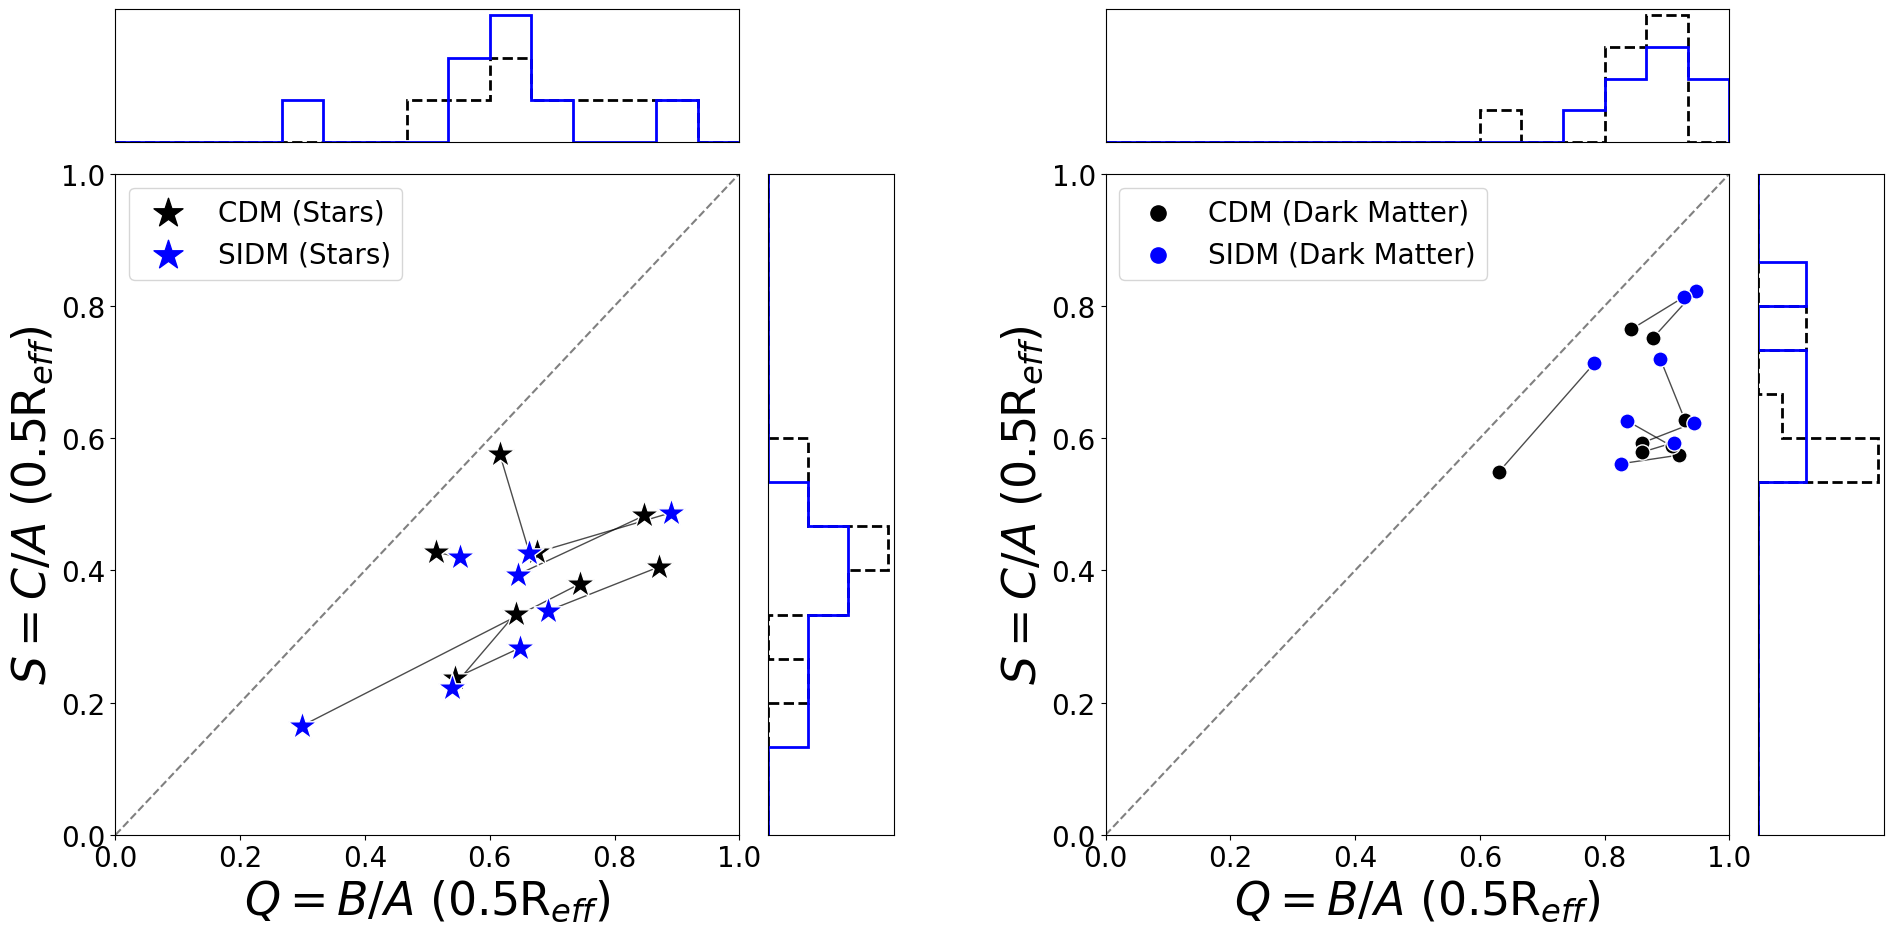

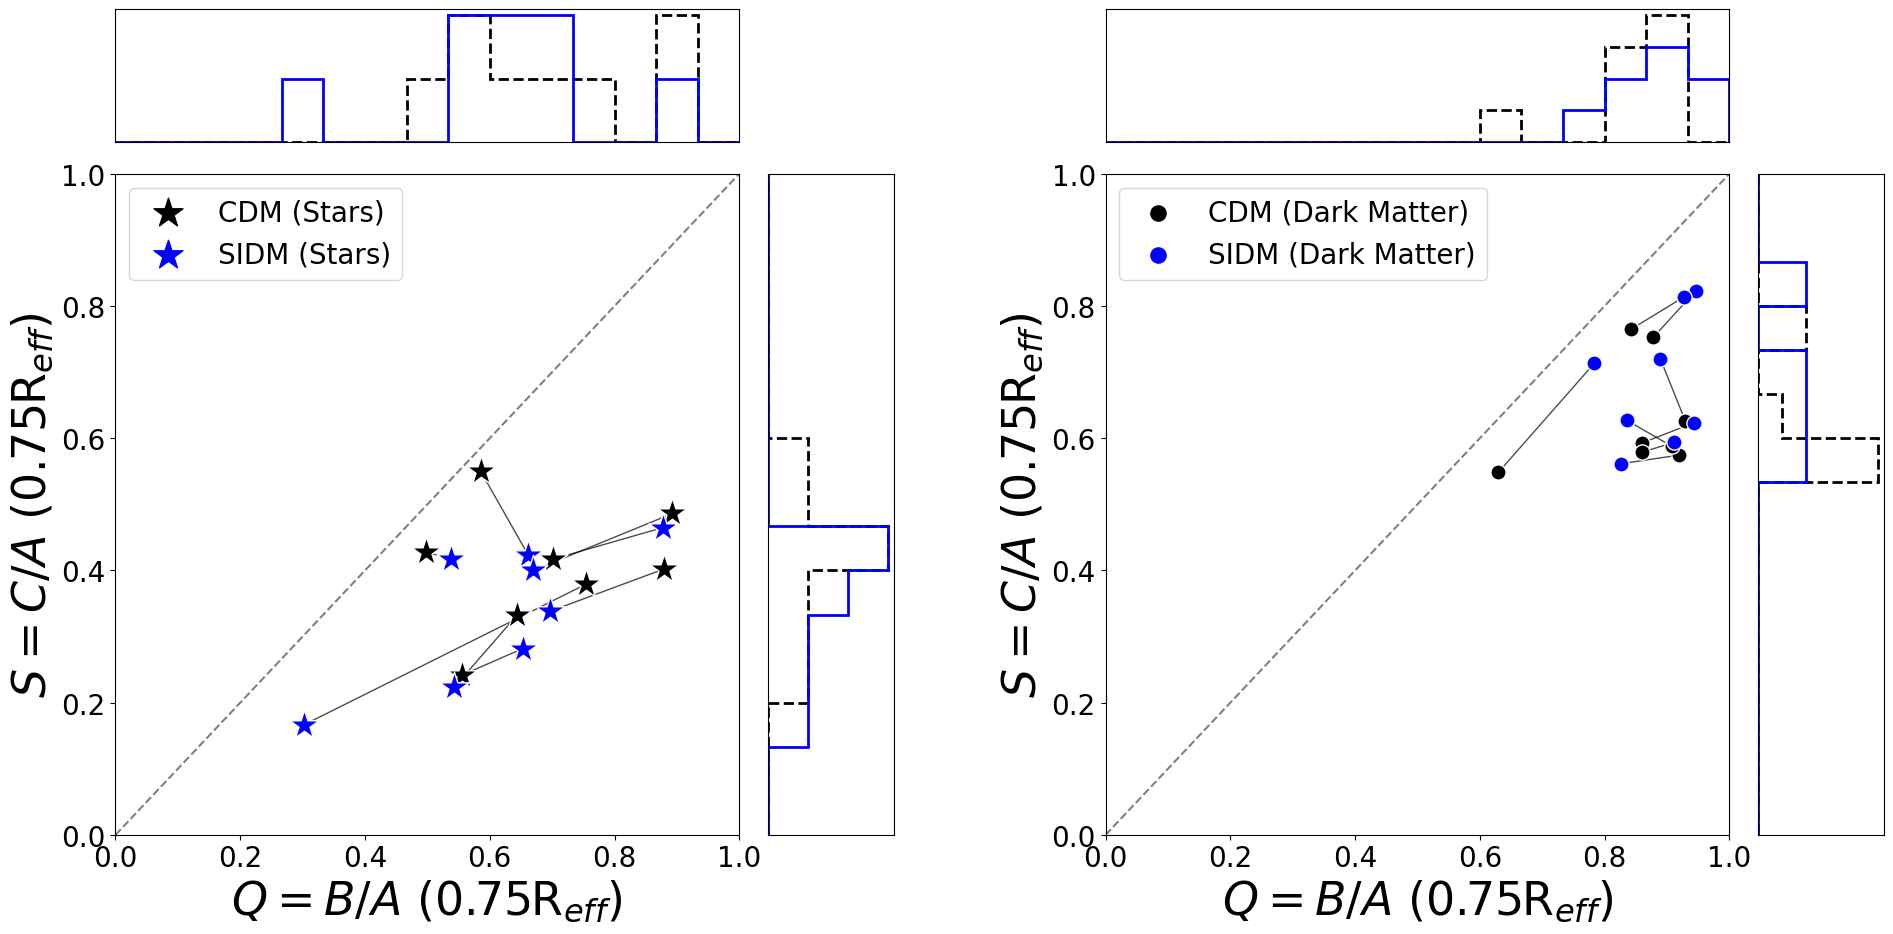

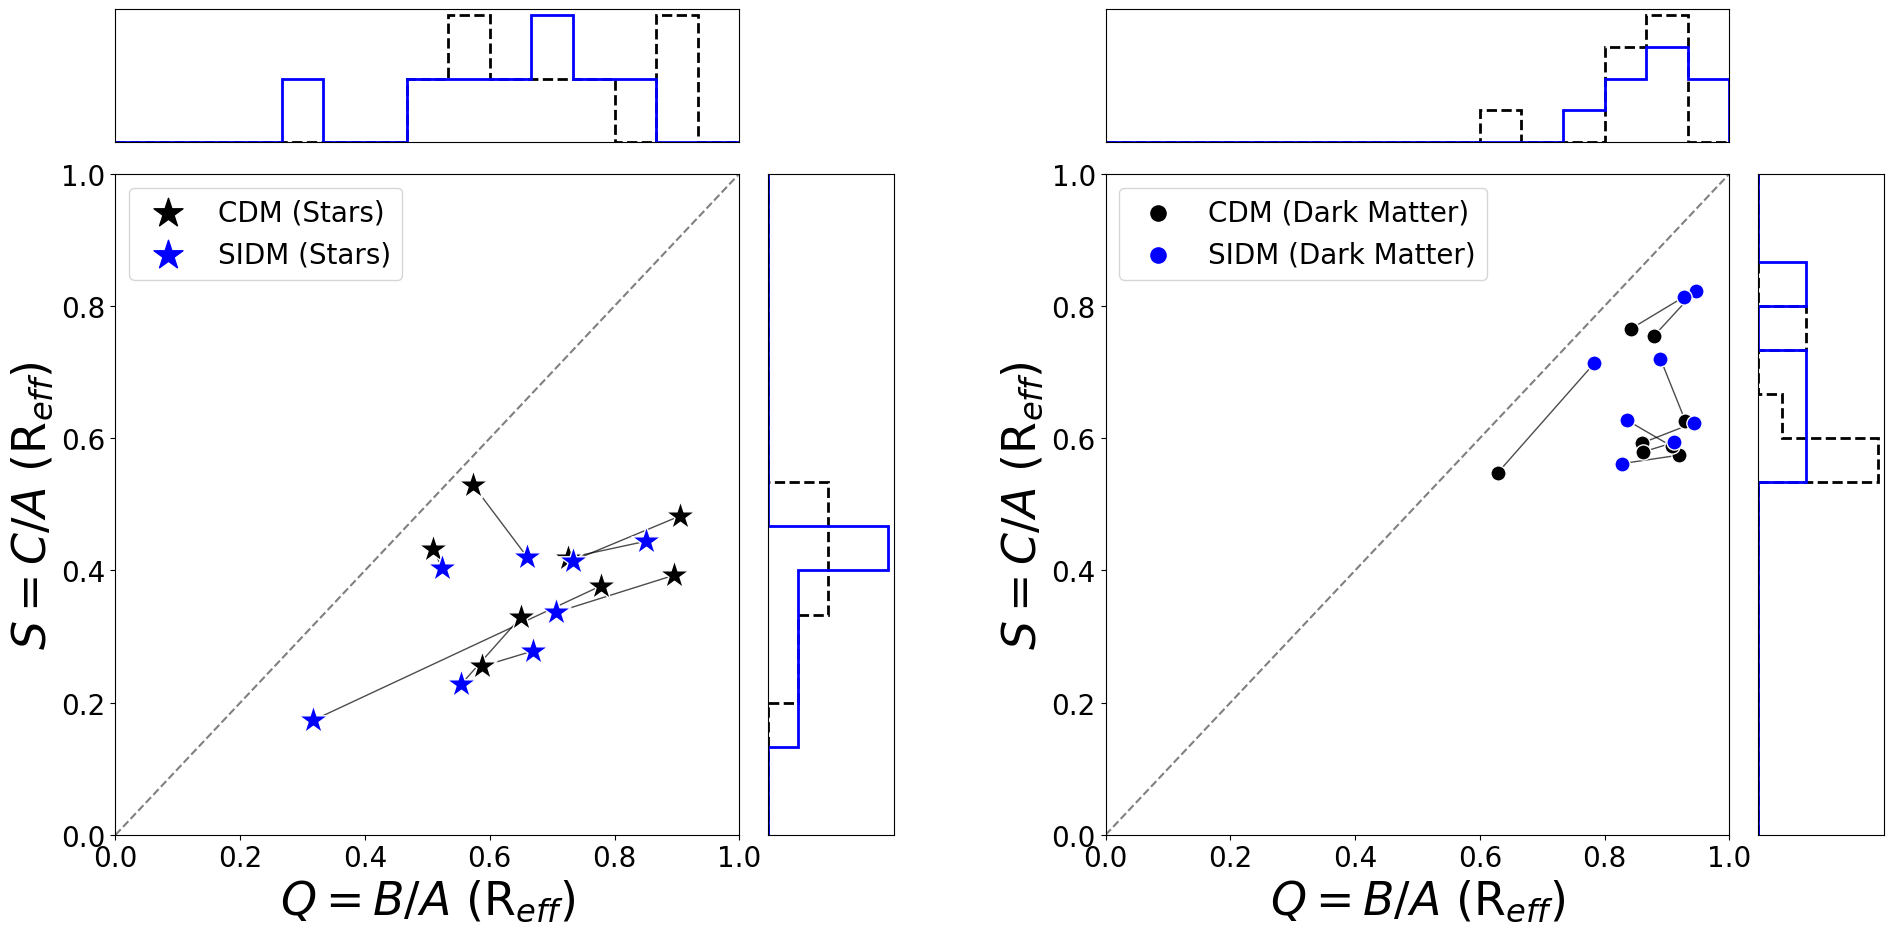

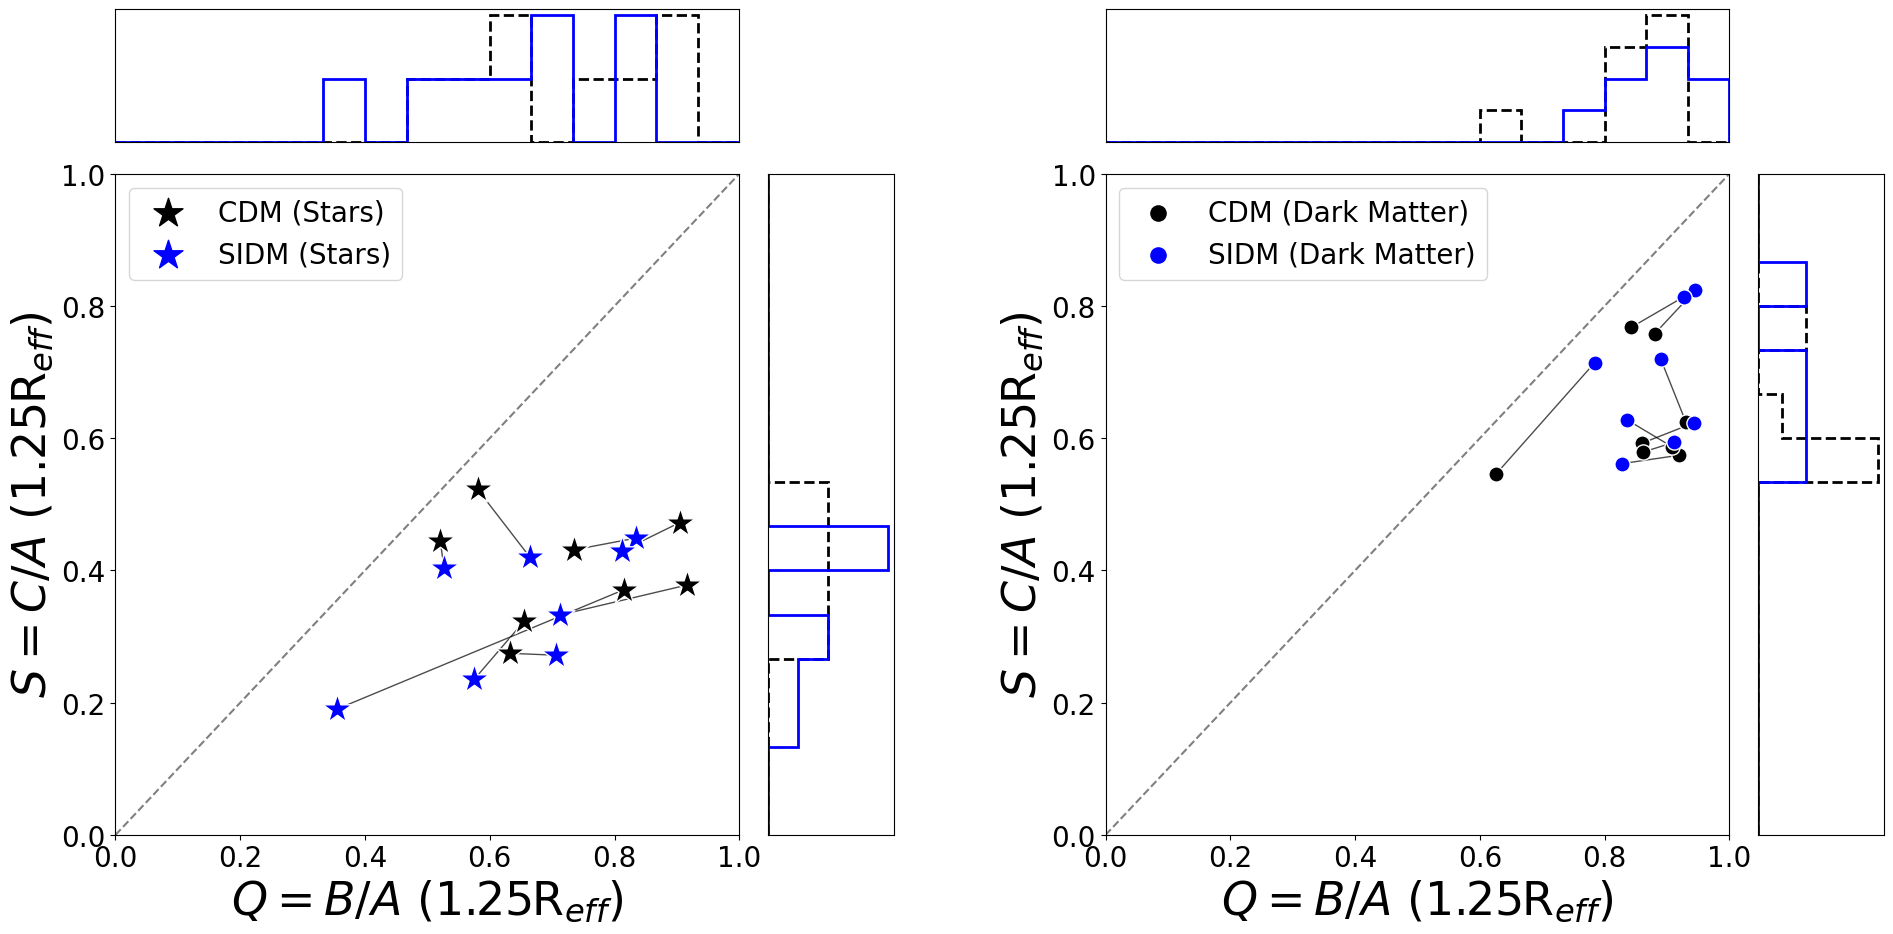

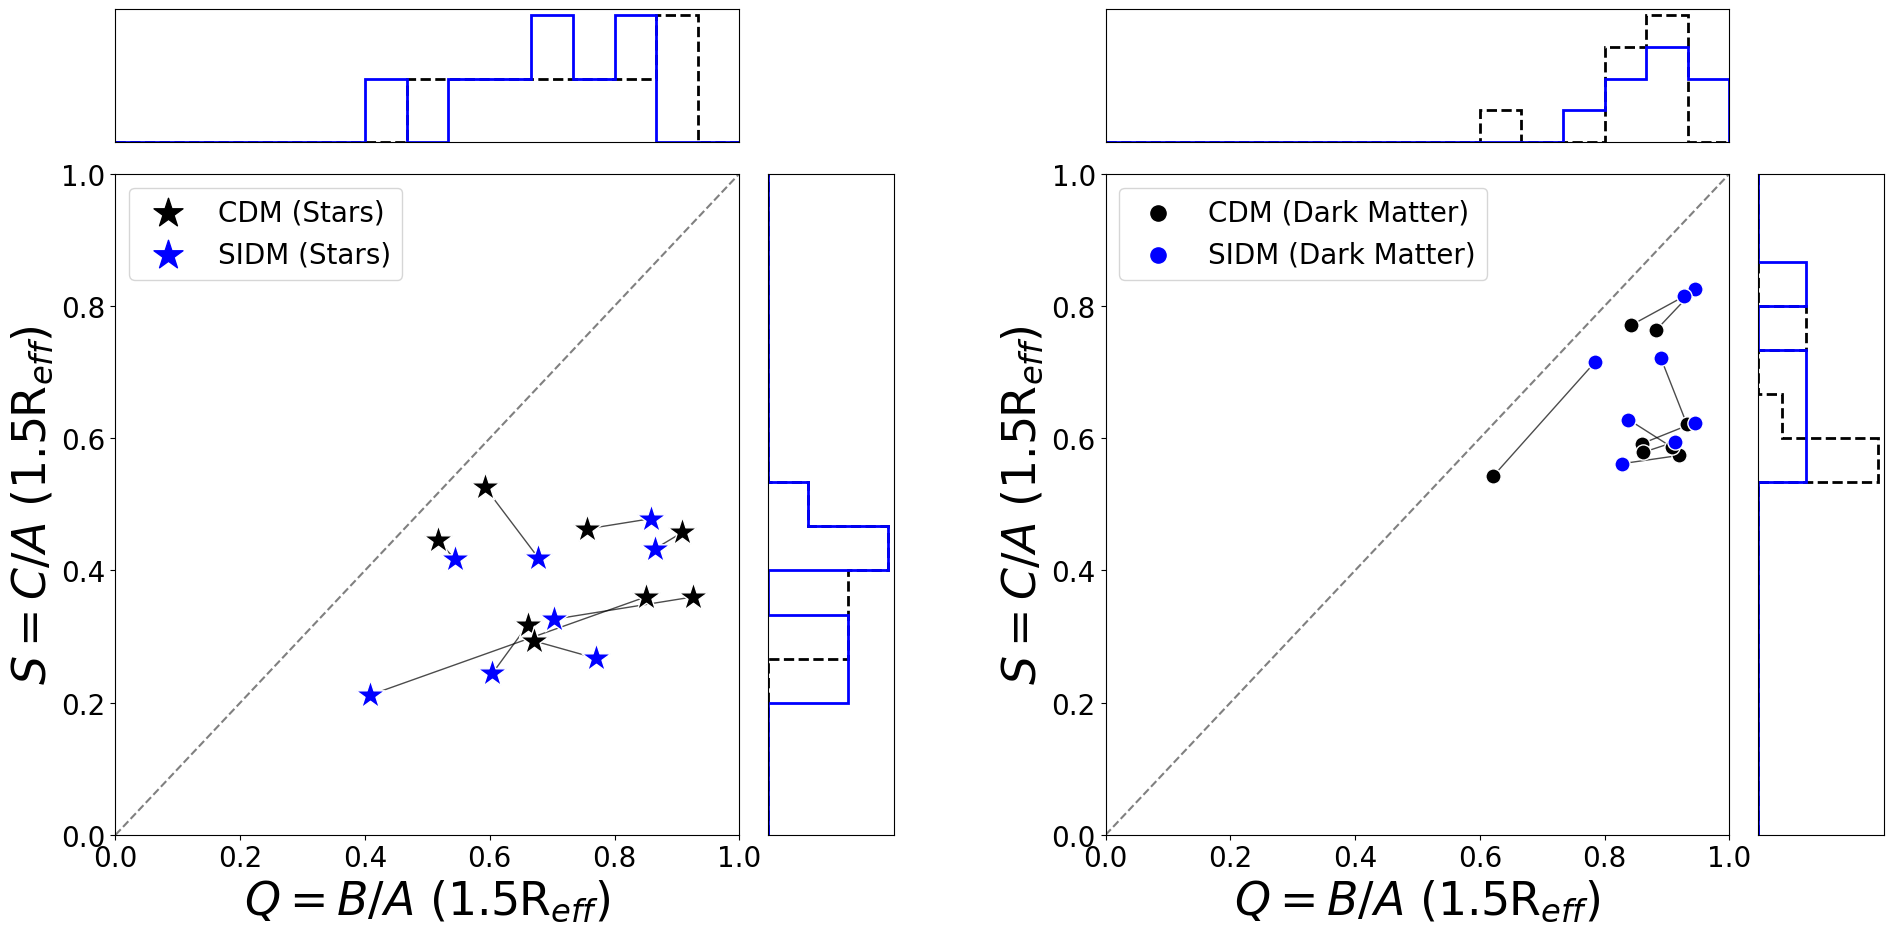

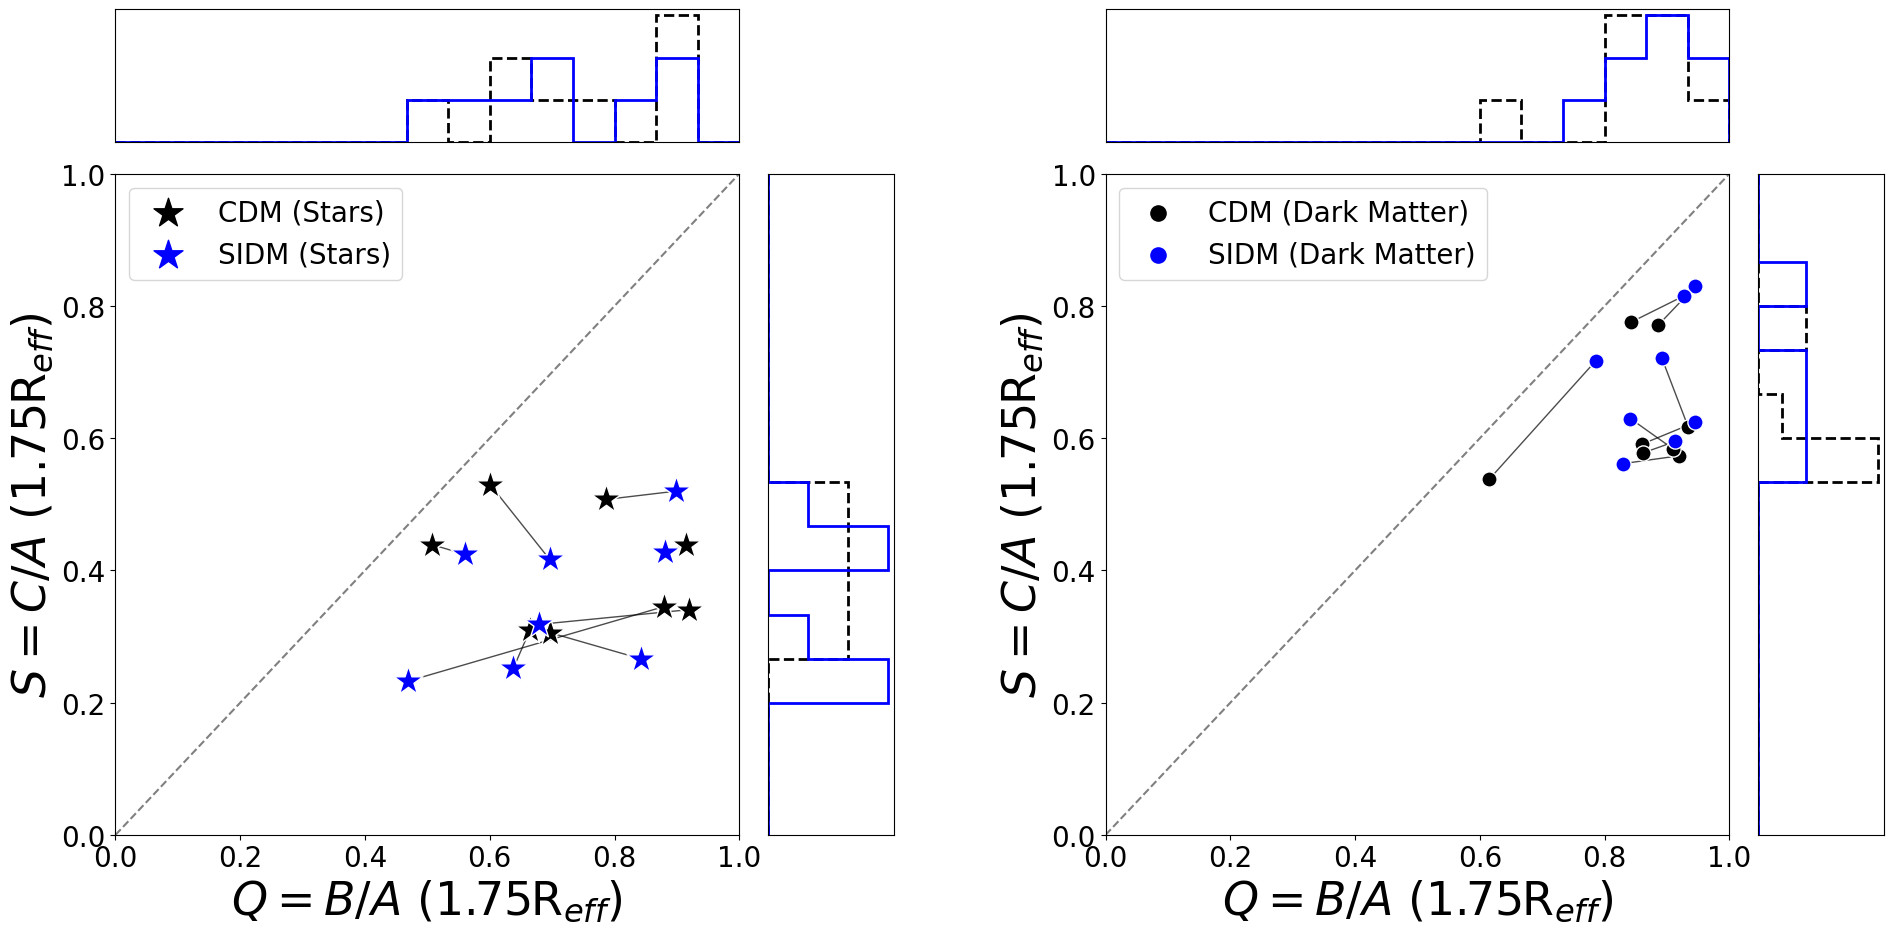

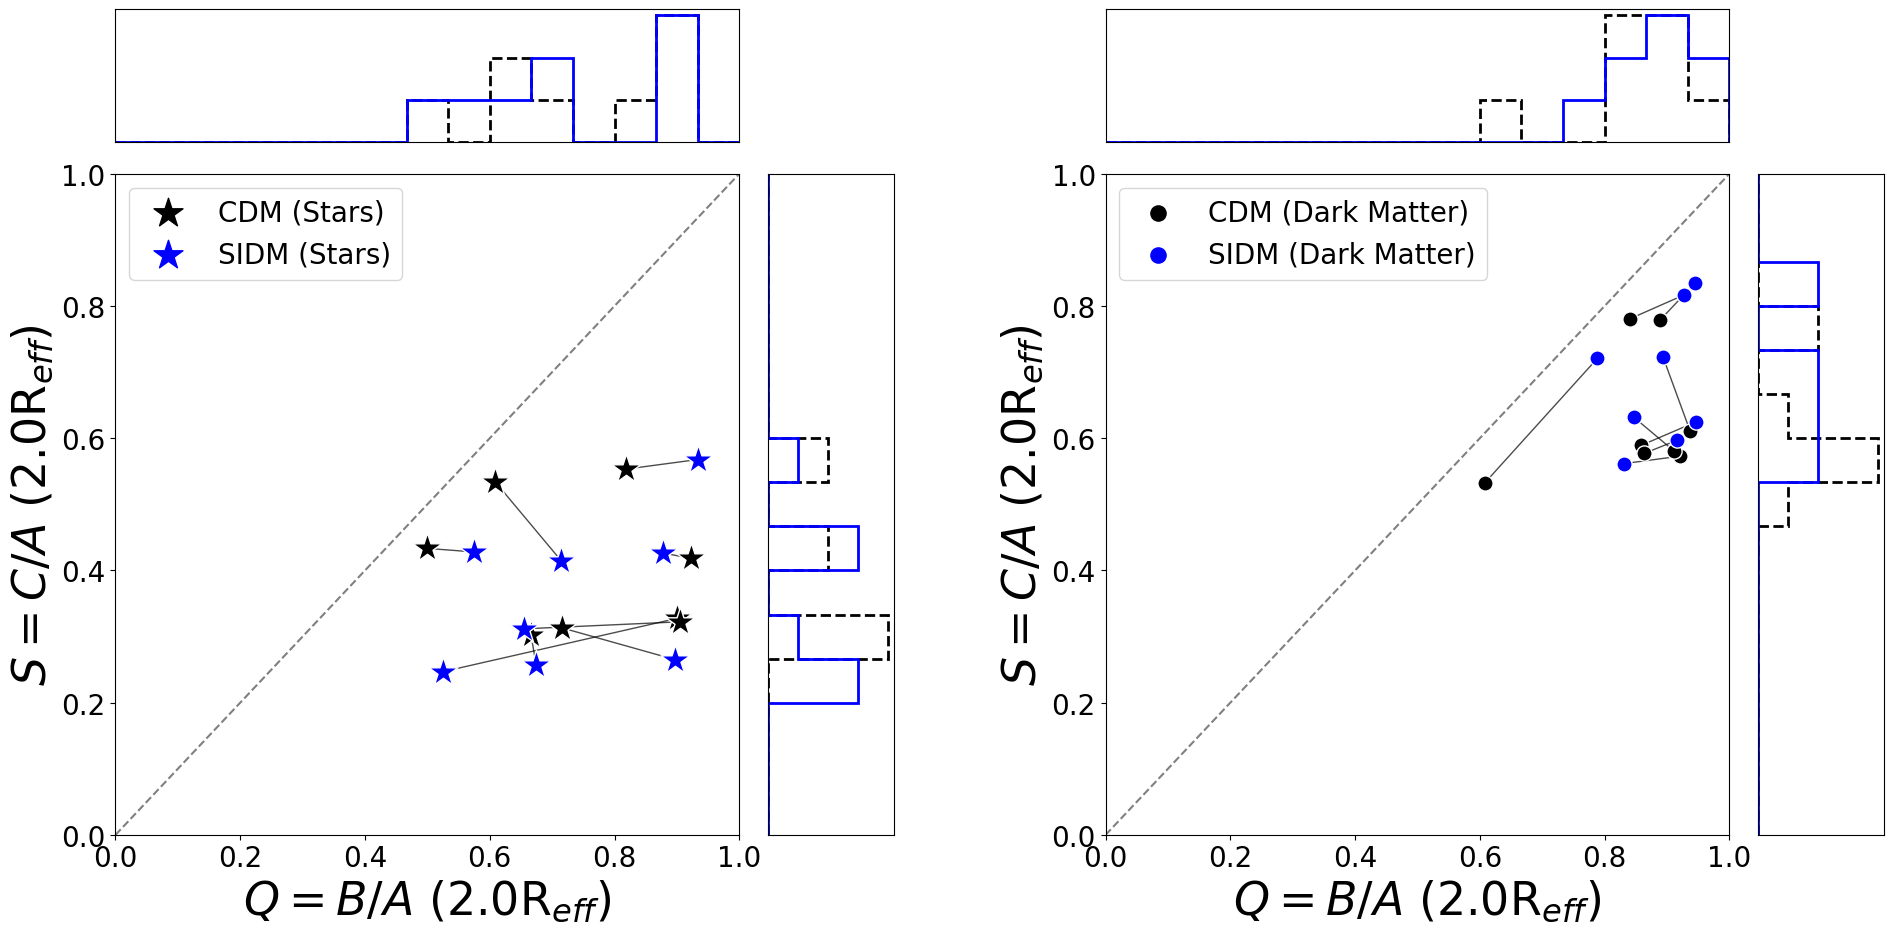

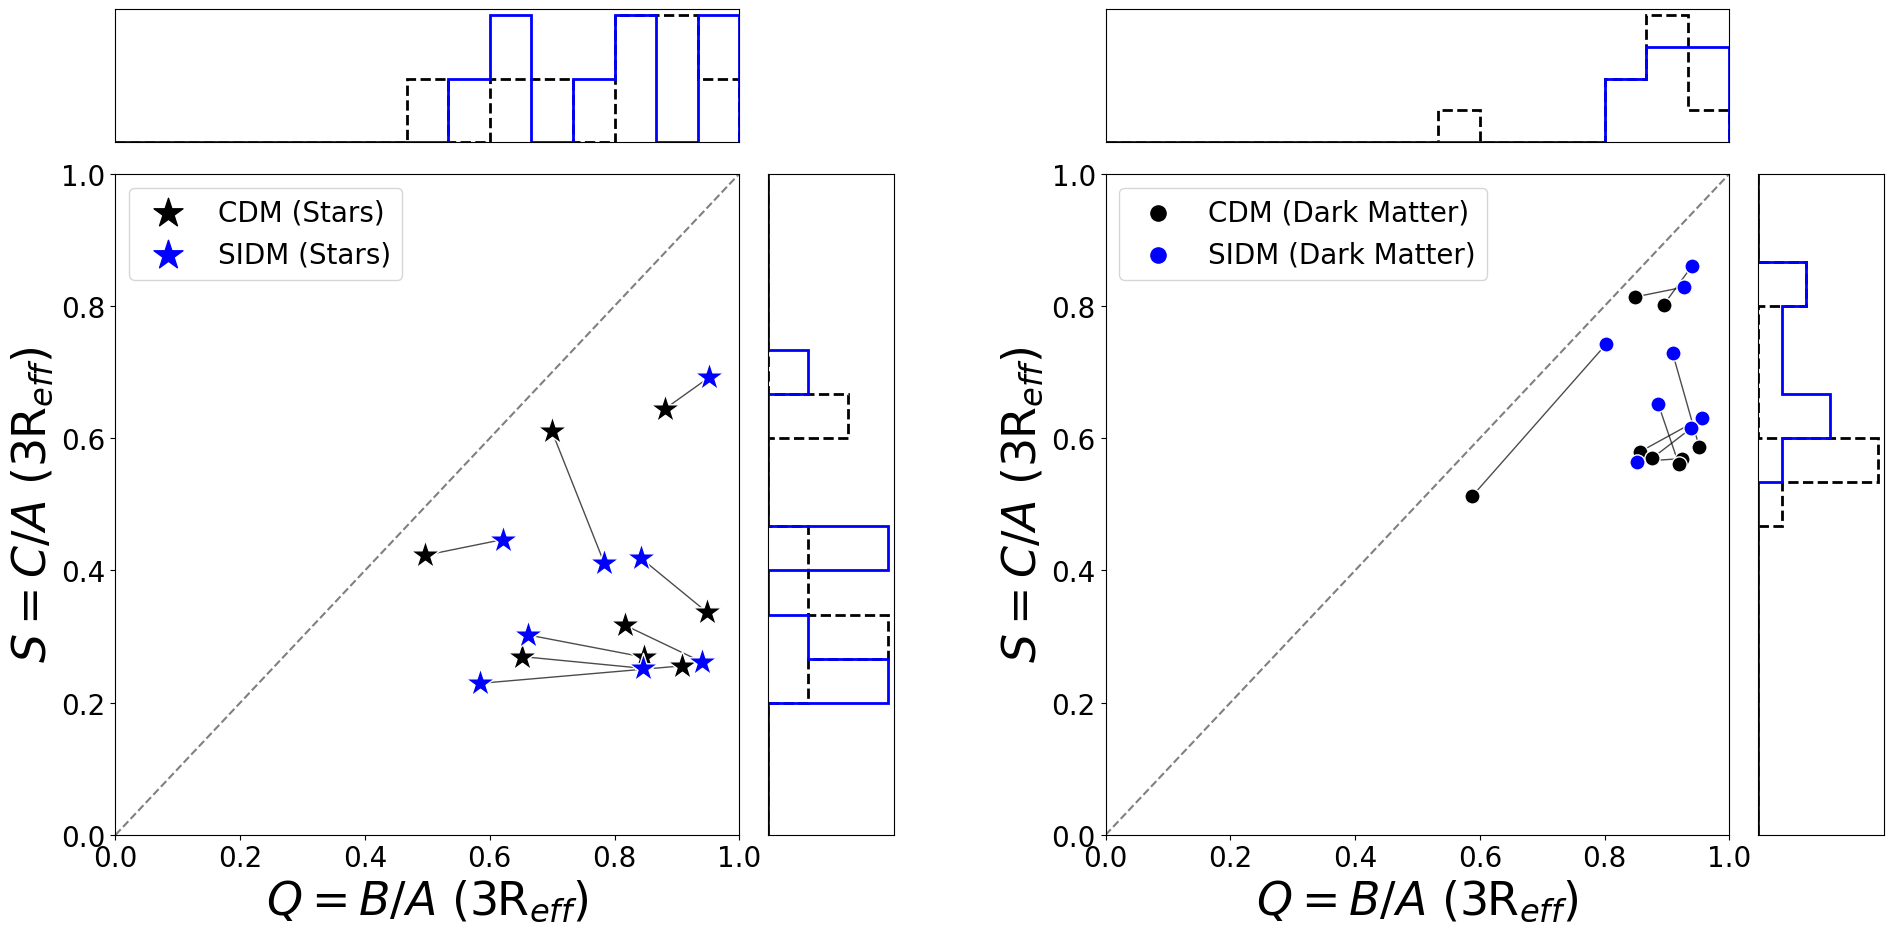

In [194]:

# import PlotClasses
# #display classes in PlotClasses
# #print(dir(PlotClasses))
# #reload(PlotClasses)
# importlib.reload(PlotClasses)
importlib.reload(sdt)

feedbacks = ['MerianCDM','MerianSIDM']

# Extract the list of simulations for each feedback type
feedbacks = ['MerianCDM', 'MerianSIDM']
sims_per_feedback = {feedback: set() for feedback in feedbacks}

for feedback in feedbacks:
    try:
        with open(f'galaxy_classifications_{feedback}.pickle', 'rb') as f:
            classified_galaxies = pickle.load(f)
            sims_per_feedback[feedback] = set(classified_galaxies.keys())
    except FileNotFoundError:
        print(f'File galaxy_classifications_{feedback}.pickle not found')


multi = [.5,.75,1.0,1.25,1.5,1.75,2.0,3]
for reff_multi in multi:
    B_s,C_s,T_s,B_d,C_d,T_d,masses,mb,mb_reff,mb_10rvir,htype,reff,mvir,feedback_type,sims,hids,mergers,rvir,diffs_at_reff, jz_jcirc_avgs,t_dyn = sdt.LoadSimData(feedbacks,return_sims=True,reff_multi=reff_multi,fixed_r=True)

    #limit sims to only those that exist in both feedbacks and update corresponding arrays B_s ....
    print(f'number in sample at reff_multi {reff_multi}: {len(sims)}')
    disk_sims = {}
    for feedback in feedbacks:
        # with open(f'galaxy_classifications_{feedback}.pickle', 'wb') as f:
        #     pickle.dump(classified_galaxies, f)
        try:
            with open(f'galaxy_classifications_{feedback}.pickle', 'rb') as f:
                classified_galaxies = pickle.load(f)
                disk_sims.update(classified_galaxies)
        except FileNotFoundError:
            print(f'File galaxy_classifications_{feedback}.pickle not found')
            continue

    # Find the intersection of these lists to get the common simulations
    common_sims = set.intersection(*sims_per_feedback.values())

    # Filter the data arrays to include only the common simulations
    common_indices = np.isin(sims, list(common_sims))
    
    print(sims[common_indices])
    print(len(sims[common_indices]))
    print(len(masses[common_indices]))

 

    # Update the data arrays
    sims = sims[common_indices]
    masses = masses[common_indices]
    disk_sims = {sim: disk_sims[sim] for sim in common_sims}
    B_s = B_s[common_indices]
    C_s = C_s[common_indices]
    T_s = T_s[common_indices]
    B_d = B_d[common_indices]
    C_d = C_d[common_indices]
    T_d = T_d[common_indices]
    mb = mb[common_indices]
    htype = htype[common_indices]
    reff = reff[common_indices]
    mvir = mvir[common_indices]
    diffs_at_reff = diffs_at_reff[common_indices]
    jz_jcirc_avgs = jz_jcirc_avgs[common_indices]
    t_dyn = t_dyn[common_indices]
    rvir = rvir[common_indices]
    mb_reff = mb_reff[common_indices]
    mb_10rvir = mb_10rvir[common_indices]
    feedback_type = feedback_type[common_indices]

    hids = hids[common_indices]
    
    mass_mask = analyze_sim_data_similarity(sims, masses, mb_reff, rvir,mvir, feedback_type)
    
    # Apply the mask to the data arrays
    sims = sims[mass_mask]
    masses = masses[mass_mask]
    disk_sims = {sim: disk_sims[sim] for sim in sims}
    B_s = B_s[mass_mask]
    C_s = C_s[mass_mask]
    T_s = T_s[mass_mask]
    B_d = B_d[mass_mask]
    C_d = C_d[mass_mask]
    T_d = T_d[mass_mask]
    mb = mb[mass_mask]
    htype = htype[mass_mask]
    reff = reff[mass_mask]
    mvir = mvir[mass_mask]
    diffs_at_reff = diffs_at_reff[mass_mask]
    jz_jcirc_avgs = jz_jcirc_avgs[mass_mask]
    t_dyn = t_dyn[mass_mask]
    rvir = rvir[mass_mask]
    mb_reff = mb_reff[mass_mask]
    mb_10rvir = mb_10rvir[mass_mask]
    feedback_type = feedback_type[mass_mask]
    hids = hids[mass_mask]
    
    



    #combine all classified galaxies


    mask = np.zeros(len(sims), dtype=bool)
    disk_mask = np.zeros(len(sims), dtype=bool)
    ellip_mask = np.zeros(len(sims), dtype=bool)
    irr_mask = np.zeros(len(sims), dtype=bool)

    for sim in disk_sims:
        for halo in disk_sims[sim]:
            disk_sim = disk_sims[sim][halo]
            # Find indices where both sims and hids match the current sim and halo
            indices = (sims == sim) & (hids == halo)
            #print(sim, halo, disk_sim)
            if disk_sim == 'd':
                disk_mask[indices] = True
            elif disk_sim == 'i':
                irr_mask[indices] = True
            elif disk_sim == 'e':
                ellip_mask[indices] = True
            else:
                print('Error: disk_sim not recognized')
                print(sim, halo)
                print(disk_sim)
                break


    folder = '../Figures/CDMvSIDM/'
    #make sure folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    data_plot = {
        'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
        'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,
        'reff_multi':reff_multi, 'feedback_type': feedback_type, 'sims': sims
    }
    
    print(data_plot)
    #mask = np.ones(len(sims),dtype=bool)
    SIDM_mask = feedback_type == 'MerianSIDM'
    CDM_mask = feedback_type == 'MerianCDM'

    #all data
    masks = {'CDM': CDM_mask,'SIDM': SIDM_mask}
    labels = {'SIDM': 'SIDM', 'CDM': 'CDM', 'B': 'Q', 'C': 'S'}
    colors = {'CDM': 'k','SIDM': 'blue'}

    print(len(SIDM_mask), len(CDM_mask), len(masses))

    plotter = GeneralPlotter(data_plot, masks, labels, colors)
    #plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder + f'SvQ.{reff_multi}.png',link_sims=False)
    plotter.plot_data_with_masks_split('B', 'C', show_lines=True, show_scatter=True, filename=folder + f'SvQ_split.{reff_multi}.png',link_sims=True)
    #plotter.calculate_shape_diff()
    #plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass.{reff_multi}.png')
    #plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter.{reff_multi}.png')
    #plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s.{reff_multi}.png')
    #plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')


    #
    #
    # #Usage example:
    # folder = '/home/bk639/OverLeaf/ShapePaper/figures/'
    # disky_mask = disk_mask
    # data_plot = {
    #     'B_s': B_s, 'C_s': C_s, 'T_s': T_s, 'B_d': B_d, 'C_d': C_d, 'T_d': T_d,
    #     'masses': masses, 'mb': mb, 'htype': htype, 'reff': reff, 'mvir': mvir,'reff_multi':reff_multi
    # }
    # masks = {'non-disky': ~disk_mask, 'disky': disk_mask}
    # labels = {'non-disky': 'Non-Disky', 'disky': 'Disky', 'B': 'Q', 'C': 'S'}
    # colors = {'non-disky': 'k', 'disky': 'blue'}
    #
    # plotter = PlotClasses.GeneralPlotter(data_plot, masks, labels, colors)
    # plotter.plot_data_with_masks('B', 'C', show_lines=True, show_scatter=True, filename=folder +  f'SvQ_disky.{reff_multi}.png')
    # plotter.calculate_shape_diff()
    # plotter.plot_triaxiality_vs_mass(filename=folder + f'T_vs_Mass_disky.{reff_multi}.png')
    # plotter.plot_T_stellar_vs_dark(filename=folder + f'T_stellar_vs_dark_matter_disky.{reff_multi}.png')
    # plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s(filename= folder + f'Mstar_V_b_d_b_s_V_c_d_c_s_disky.{reff_multi}.png')
    # plotter.plot_q_s_q_d(filename=folder + f'q_s_q_d_and_s_s_s_d.{reff_multi}.png')



[0.75338792 0.77968228 0.79131804 0.78793635 0.8204538  0.81843697
 0.84615354 0.84536606]
[0.8732728  0.6256901  0.79365706 0.59549784 0.81177067 0.76325758
 0.80250784 0.74483038]


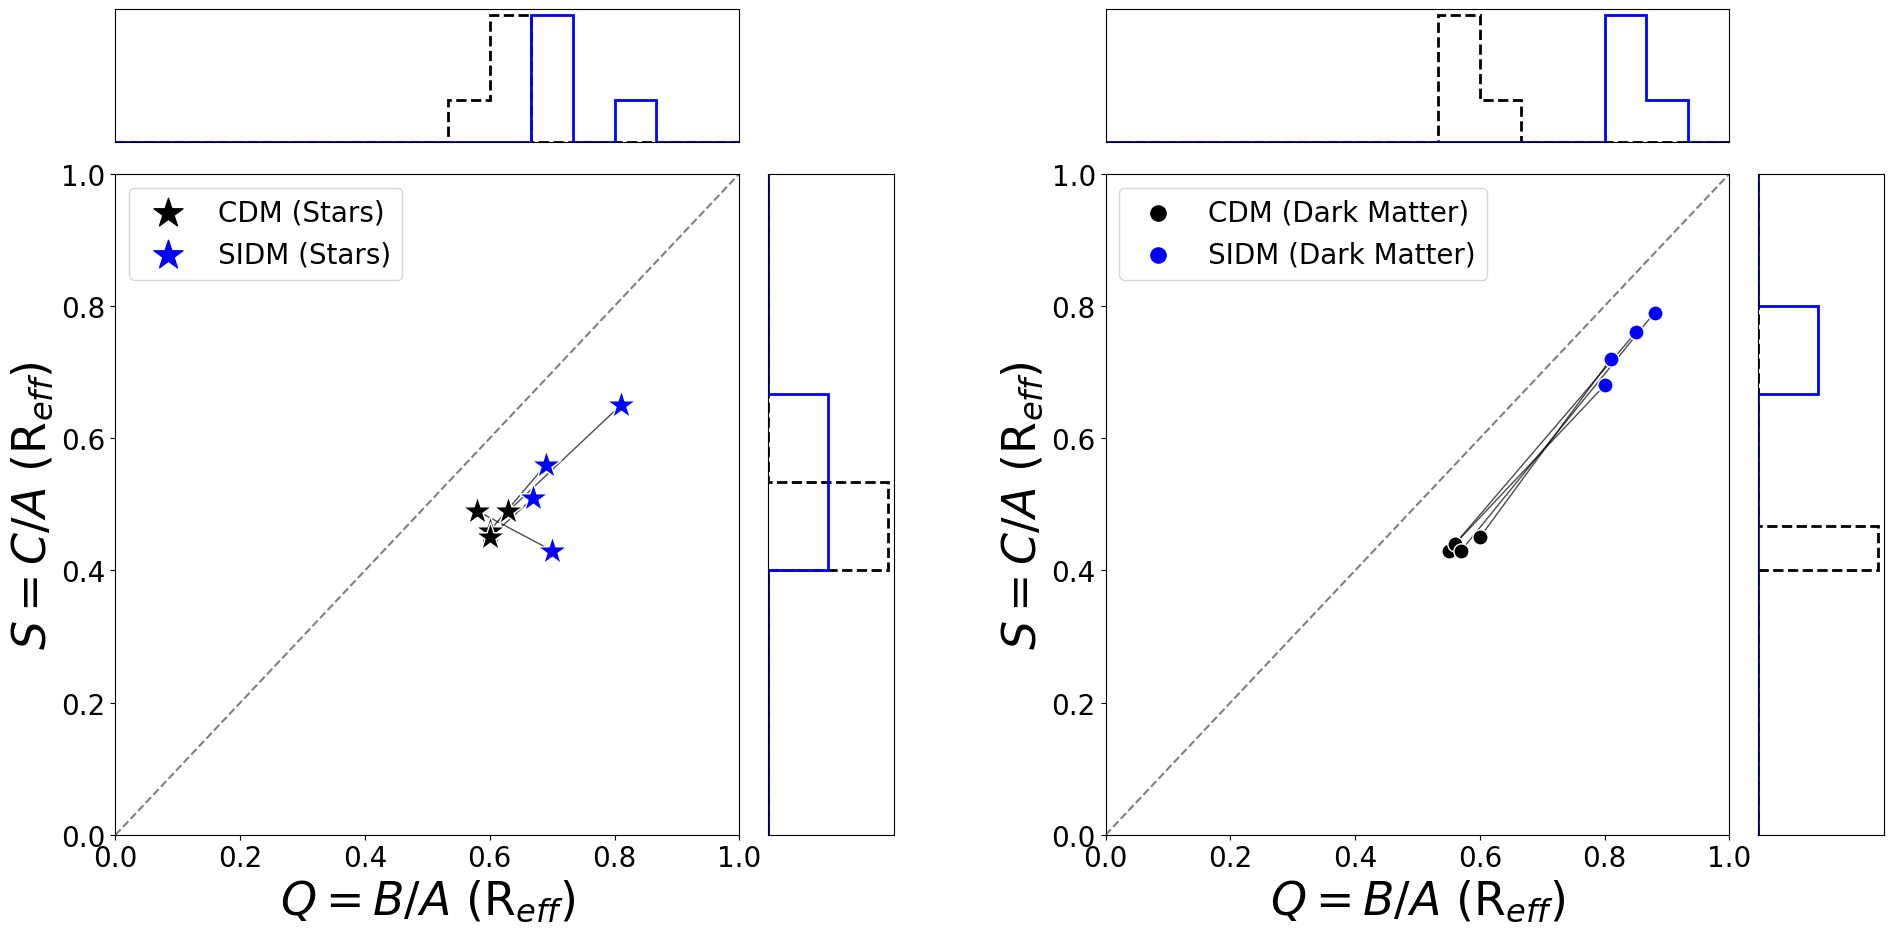

/tmp/ipykernel_775810/3955600426.py:352: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma')


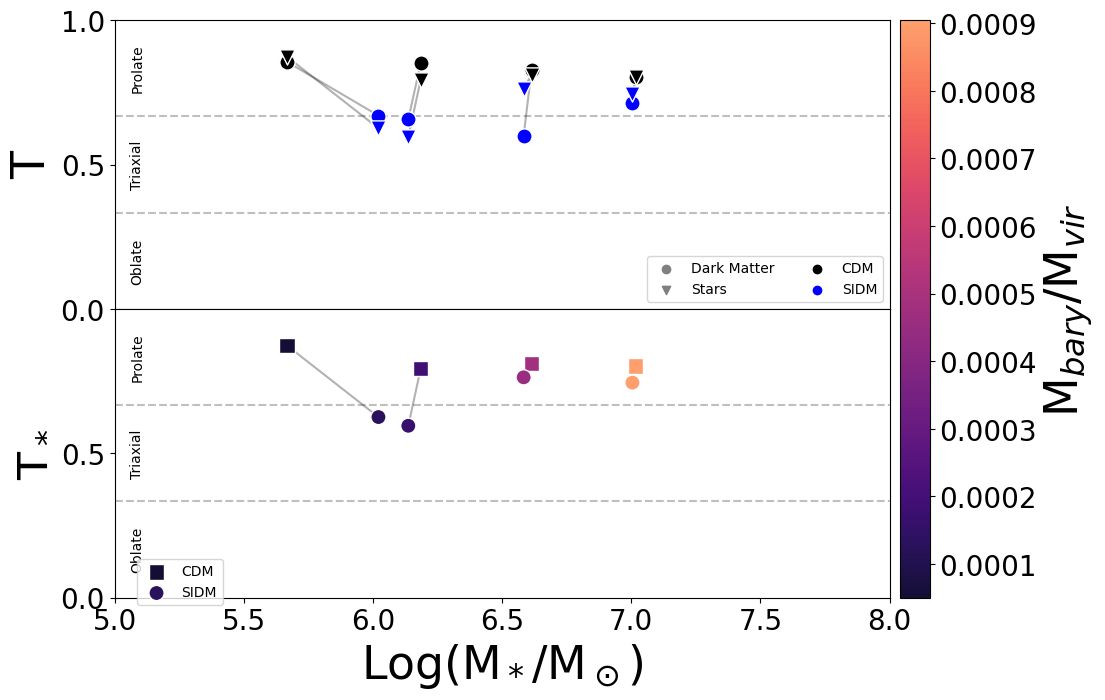

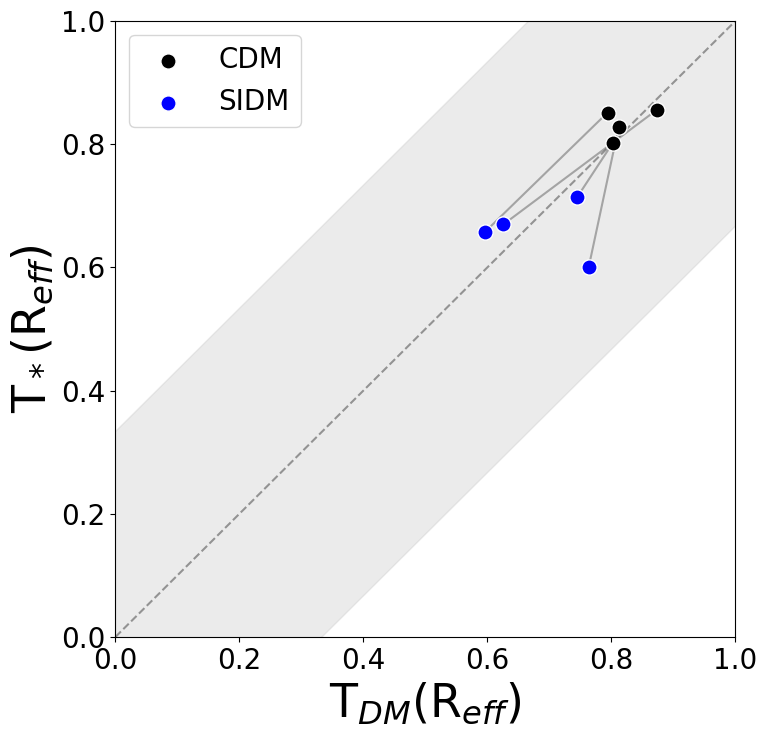

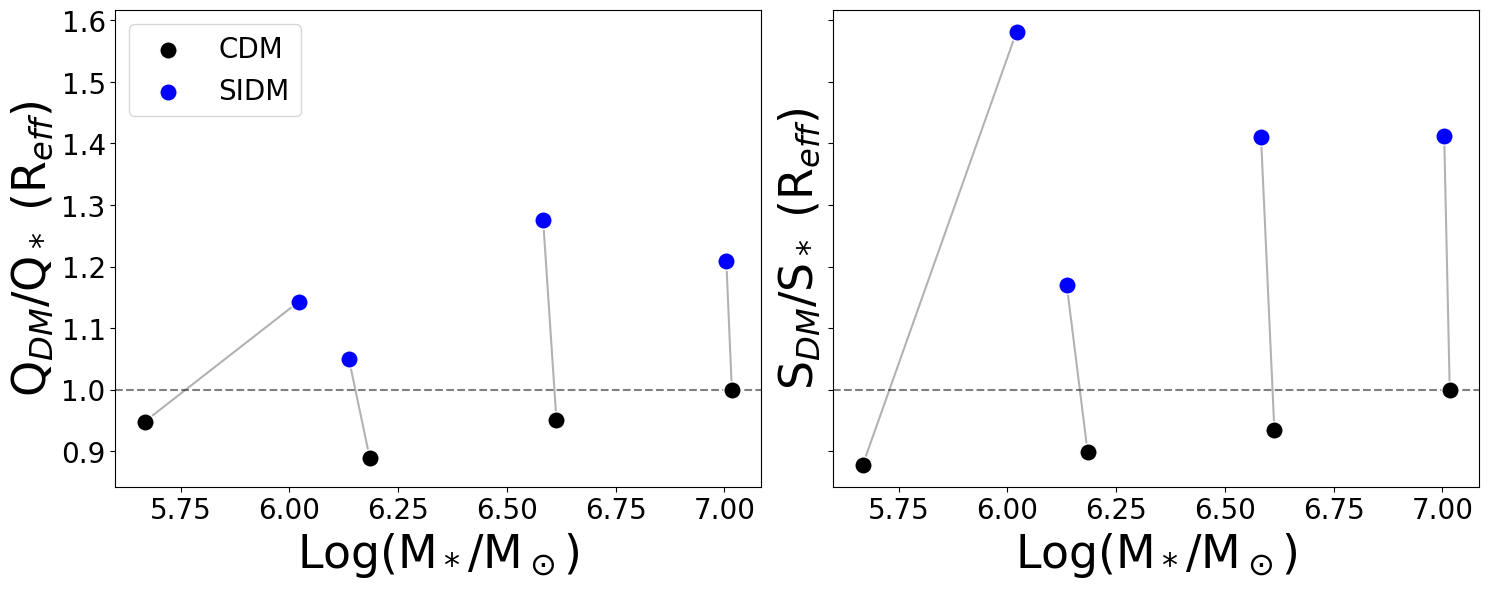

/tmp/ipykernel_775810/3955600426.py:510: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma = plt.cm.get_cmap('magma')


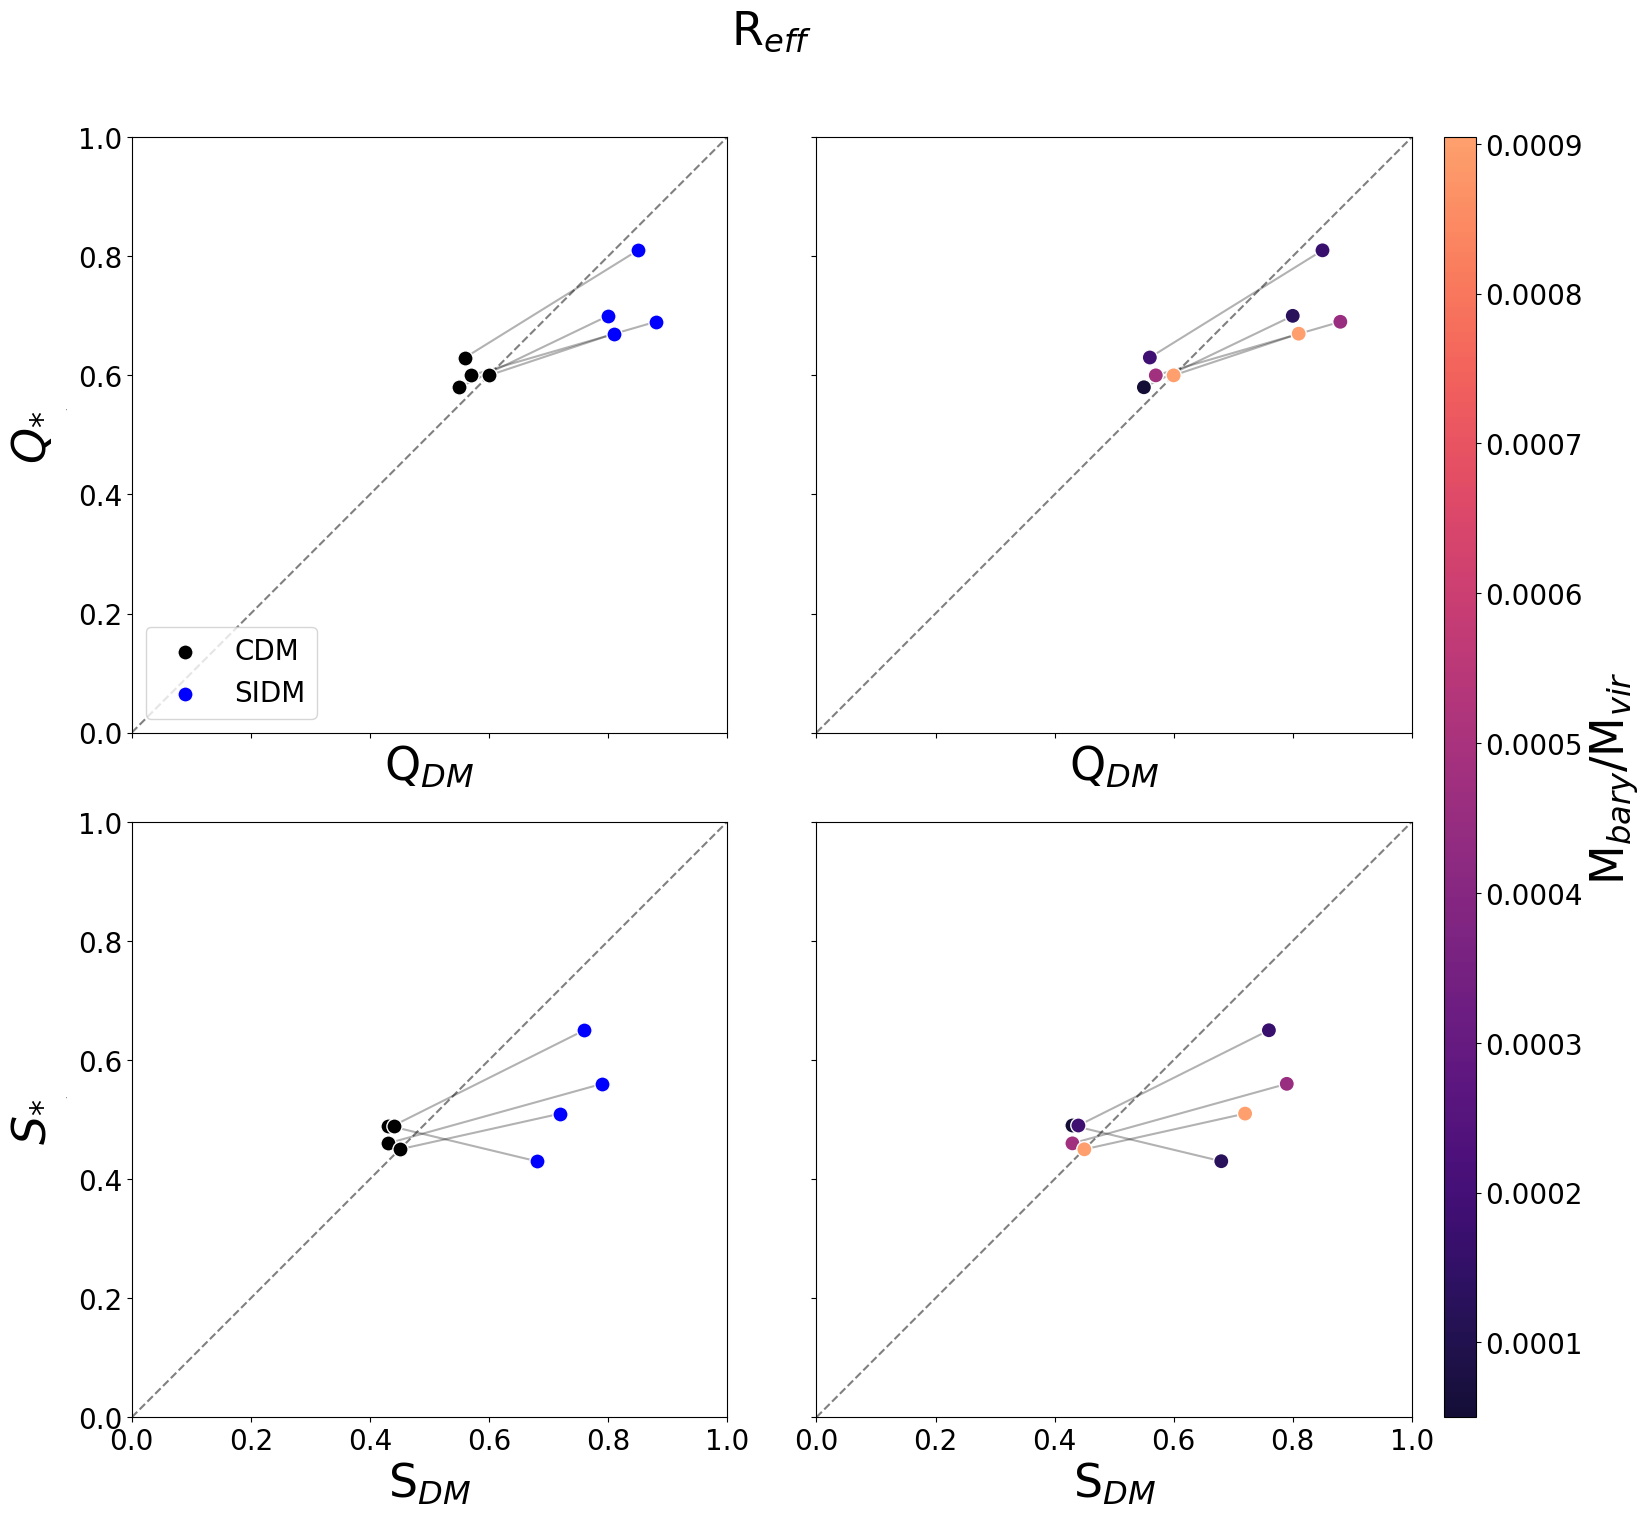

In [193]:
import numpy as np

def T(ba, ca):
    return ((1 - ba ** 2) / (1 - ca ** 2))

# Existing data
B_d_dmo = {'m10b': [0.50, 0.90], 'm10d': [0.57, 0.87], 'm10f': [0.52, 0.95], 'm10k': [0.55, 0.94]}
C_d_dmo = {'m10b': [0.38, 0.76], 'm10d': [0.44, 0.84], 'm10f': [0.42, 0.91], 'm10k': [0.41, 0.85]}
B_d = {'m10b': [0.55, 0.80], 'm10d': [0.56, 0.85], 'm10f': [0.57, 0.88], 'm10k': [0.60, 0.81]}
C_d = {'m10b': [0.43, 0.68], 'm10d': [0.44, 0.76], 'm10f': [0.43, 0.79], 'm10k': [0.45, 0.72]}
B_s = {'m10b': [0.58, 0.70], 'm10d': [0.63, 0.81], 'm10f': [0.60, 0.69], 'm10k': [0.60, 0.67]}
C_s = {'m10b': [0.49, 0.43], 'm10d': [0.49, 0.65], 'm10f': [0.46, 0.56], 'm10k': [0.45, 0.51]}

# New data from Table 1
M_vir = {'m10b': [9.29e9, 8.13e9], 'm10d': [8.43e9, 8.10e9], 'm10f': [8.56e9, 8.39e9], 'm10k': [1.15e10, 1.12e10]}
V_max = {'m10b': [31.5, 30.8], 'm10d': [32.1, 33.1], 'm10f': [35.7, 35.7], 'm10k': [38.2, 37.6]}
M_star = {'m10b': [4.65e5, 1.05e6], 'm10d': [1.53e6, 1.37e6], 'm10f': [4.11e6, 3.83e6], 'm10k': [1.04e7, 1.01e7]}
r_half = {'m10b': [340, 504], 'm10d': [530, 591], 'm10f': [750, 838], 'm10k': [1140, 1260]}
V_max_dmo = {'m10b': [34.8, 31.8], 'm10d': [37.6, 34.5], 'm10f': [41.2, 38.8], 'm10k': [43.5, 40.4]}
M_hydro_M_dmo = {'m10b': [0.96, 0.90], 'm10d': [0.98, 0.94], 'm10f': [0.94, 0.93], 'm10k': [0.96, 0.94]}

# Create lists for each parameter
B_s_list, C_s_list, B_d_list, C_d_list = [], [], [], []
M_vir_list, V_max_list, M_star_list, r_half_list, V_max_dmo_list, M_hydro_M_dmo_list = [], [], [], [], [], []
sims, feedback_type = [], []

for sim in ['m10b', 'm10d', 'm10f', 'm10k']:
    for i, ft in enumerate(['MerianCDM', 'MerianSIDM']):
        B_s_list.append(B_s[sim][i])
        C_s_list.append(C_s[sim][i])
        B_d_list.append(B_d[sim][i])
        C_d_list.append(C_d[sim][i])
        M_vir_list.append(M_vir[sim][i])
        V_max_list.append(V_max[sim][i])
        M_star_list.append(M_star[sim][i])
        r_half_list.append(r_half[sim][i])
        V_max_dmo_list.append(V_max_dmo[sim][i])
        M_hydro_M_dmo_list.append(M_hydro_M_dmo[sim][i])
        sims.append(sim)
        feedback_type.append(ft)

# Create the data_plot dictionary
data_plot = {
    'B_s': np.array(B_s_list),
    'C_s': np.array(C_s_list),
    'B_d': np.array(B_d_list),
    'C_d': np.array(C_d_list),
    'T_s': T(np.array(B_s_list), np.array(C_s_list)),
    'T_d': T(np.array(B_d_list), np.array(C_d_list)),
    'masses': np.log10(np.array(M_star_list)),  # Using M_star as masses
    'sims': np.array(sims),
    'feedback_type': np.array(feedback_type),
    'reff_multi': 1.0,
    'mb': np.array(M_star_list)/np.array(M_vir_list),  # Using M_hydro_M_dmo as mb
    'M_vir': np.array(M_vir_list),
    'V_max': np.array(V_max_list),
    'r_half': np.array(r_half_list),
    'V_max_dmo': np.array(V_max_dmo_list),
}

#print masses and triaxiality in the data_plot
print(np.log10(data_plot['masses']))
print(data_plot['T_s'])


# Create masks
SIDM_mask = data_plot['feedback_type'] == 'MerianSIDM'
CDM_mask = data_plot['feedback_type'] == 'MerianCDM'

masks = {'CDM': CDM_mask, 'SIDM': SIDM_mask}
labels = {'SIDM': 'SIDM', 'CDM': 'CDM', 'B': 'Q', 'C': 'S'}
colors = {'CDM': 'k', 'SIDM': 'blue'}

# Create the plotter object
plotter = GeneralPlotter(data_plot, masks, labels, colors)

# Now you can use the plotter object to create your plots
# For example:
plotter.plot_data_with_masks_split('B', 'C', show_lines=True, show_scatter=True, link_sims=True)
plotter.plot_triaxiality_vs_mass()
plotter.plot_T_stellar_vs_dark()
plotter.plot_Mstar_V_b_d_b_s_V_c_d_c_s()
plotter.plot_q_s_q_d()

# Additional plots using new data could be added here
# plotter.plot_data_with_masks_split('M_vir', 'V_max', show_lines=True, show_scatter=True, link_sims=True)
# plotter.plot_data_with_masks_split('masses', 'r_half', show_lines=True, show_scatter=True, link_sims=True)